In [1]:
#Getting path to ImageFeatures Library
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn import linear_model,ensemble,metrics,preprocessing
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import cv2
from ImageFeatures import *
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Labels for all images
main_images = pd.read_csv('/Users/richardknoche/DecoRater/AptDecoData/HighRes_ManuallyLabeled.csv')
main_images.drop('Unnamed: 0',axis=1,inplace=True)

#Features for all images
image_features = pd.read_csv('/Users/richardknoche/DecoRater/AptDecoData/HighRes_ImageFeatures.csv')
image_features.drop('Unnamed: 0',axis=1,inplace=True)

#Merge the two df
df = main_images.merge(image_features,how="inner",on="path")

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
#Drop na and edited (Rating=4) images
df.dropna(inplace=True)
df = df[df['Rating']<4]

#Change to high quality (class 3) and low quality (class 1 and 2) labels
df['Rating'] = df['Rating']==3

In [3]:
#Features used in the model
features = ['g_xgrad', 'r_ygrad', 'g_ygrad', 'Complimentary_Color_Level', 'B_Width', 'Salient_Saturation',
            'H_mean', 'b_xgrad', 'Thirds_Vertical_Saliency_Sym', 'Lapacian_Hue', 'Lapacian_Value',
            'Thirds_Horizontal_Value_Sym', 'R_xgrad', 'b_ygrad_std', 'Horizontal_Hue_Sym', 'Vertical_Value_Sym',
            'r_ygrad_std', 'Thirds_Vertical_Value_Sym', 'S_var', 'Thirds_Sat', 'b_xgrad_std', 'Image_Size',
            'Thirds_Saliency', 'S_mean', 'Thirds_Vertical_Saturation_Sym', 'Thirds_Hue', 'Thirds_Vertical_Hue_Sym',
            'Vertical_Hue_Sym', 'standard_luminance', 'Laplacian_Sharpness', 'Aspect_Ratio', 'Thirds_Value',
            'FFT_Sharpness', 'Thirds_To_Focal_Distance', 'G_Width', 'r_xgrad_std', 'Lapacian_Saturation',
            'Horizontal_Saturation_Sym', 'H_var', 'V_mean', 'V_var', 'Salient_Hue', 'G_Mean', 'Histogram_Darkness',
            'Colorfulness', 'percieved_luminace', 'Salient_Value', 'Busyness', 'g_xgrad_std', 'R_Width', 'Number_of_Contours',
            'g_ygrad_std', 'b_ygrad', 'B_Mean', 'Horizontal_Value_Sym', 'Thirds_Horizontal_Saliency_Sym',
            'Thirds_Horizontal_Hue_Sym', 'Vertical_Saturation_Sym', 'R_Mean', 'Thirds_Horizontal_Saturation_Sym']


# Making Test/CV/Train Sets

In [4]:
'''Downsampling works better than upsampling here.
Also works better than automatically changing model weights with sklearn'''

#Counting number of images in each class
col_to_predict = 'Rating'
num_minority = min(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))
num_majority = max(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))

#Splitting into sub data frames
true_df  = df[df[col_to_predict]==True]
false_df = df[df[col_to_predict]==False]

#Downsampling to make training set
train_true  = true_df.sample(n=np.floor(num_minority*0.6),random_state = 102)
train_false = false_df.sample(n=np.floor(num_minority*0.6),random_state = 102) #Using 2*num_minority, since we supliment later
train = pd.concat([train_true,train_false])

#Making test set with accurate ratio of high to low quality
test  = df.drop(train.index)
test1 = test[test['Rating']==1]
test2 = test[test['Rating']==0].sample(n=np.floor(len(test1)*num_majority/num_minority),random_state=50)
test  = pd.concat([test1,test2])

#Use 50% of test set as CV set
cv = test.sample(frac=0.5,random_state=102)
test = test.drop(cv.index)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


In [5]:
#Setting up x and y data for the model
train_x = train[features]
train_y = train[col_to_predict]

test_x = test[features]
test_y = test[col_to_predict]

cv_x = cv[features]
cv_y = cv[col_to_predict]

# Training and Tuning the model

In [6]:
#Making a function for evaluating the model
def EvaluateModel(x,y):
    
    #Get predictions and probabilities
    predicted_y = clf.predict(x)
    y_probs =clf.predict_proba(x)[:, 1]

    #Make ROC
    fpr, tpr, thresholds = metrics.roc_curve(y, y_probs)
    sns.set_style("whitegrid")
    blue, = sns.color_palette("muted", 1)
    fig = plt.figure(figsize=(20,14))
    ax = plt.gca()
    ax.plot(fpr, tpr, color=blue, lw=3)
    ax.fill_between(fpr, 0, tpr, alpha=.3)
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False positive rate',size=60)
    ax.set_ylabel('True positive rate',size=60)
    ax.set_title('ROC Curve',size=60)
    ax.set_xticklabels(np.linspace(0,1,6),size=50)
    ax.set_yticklabels(np.linspace(0,1,6),size=50)
    ax.text(0.8,0.1,"AUC: %0.2f" % metrics.auc(fpr, tpr),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=0.5'),size=50)


    #Accuracy, Precision, Recall
    print('Accuracy: ',clf.score(x,y))
    f1score, tpr, thresholds = metrics.roc_curve(y, y_probs)

    precision, recall, thresholds = precision_recall_curve(y,y_probs)
    average_precision = average_precision_score(y, y_probs)
    print(average_precision)


    #Prec-Recall Curve
    fig = plt.figure(figsize=(20,14))
    ax = plt.gca()
    ax.plot(recall, precision, color=blue, lw=3)
    ax.fill_between(recall, 0, precision, alpha=.3)
    ax.set_xlabel('Recall',size=60)
    ax.set_ylabel('Precision',size=60)
    ax.set_title('PR Curve',size=60)
    ax.set_xticklabels(np.linspace(0,1,6),size=50)
    ax.set_yticklabels(np.linspace(0,1,6),size=50)


    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y, predicted_y)
    classifier_metrics = pd.DataFrame( {'Precision' : precision, 'Recall' : recall, 'F-Score' : fscore, 'Support' : support})
    classifier_metrics.index=['Bad','Good']

    import pylab as pl
    labels = ['Low Quality', 'High Quality']

    cm = metrics.confusion_matrix(y, predicted_y)
    cm = (cm[0]/np.sum(cm[0]),cm[1]/np.sum(cm[1]))


    fig = plt.figure(figsize=(20,14))
    ax = plt.gca()
    ax.grid(False)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap='Blues')
    pl.title('Confusion Matrix',size=60)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel('Percentage',size=60)
    cbar.ax.tick_params(labelsize=50) 
    ax.set_xticklabels([''] + labels,size=50)
    ax.set_yticklabels([''] + labels,size=50)
    ax.xaxis.set_ticks_position('bottom')
    pl.xlabel('Predicted',size=60)
    pl.ylabel('True',size=60)

    pl.text(0,0,'Neg Frac \n Correct: %.2f'% cm[0][0],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.text(0,1,'Pos Frac \n Wrong: %.2f'% cm[1][0],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.text(1,0,'Neg Frac \n Wrong: %.2f'% cm[0][1],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.text(1,1,'Pos Frac \n Correct: %.2f'% cm[1][1],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.show()
    
    print(classifier_metrics.head())

Accuracy:  0.654986522911
0.405955205688


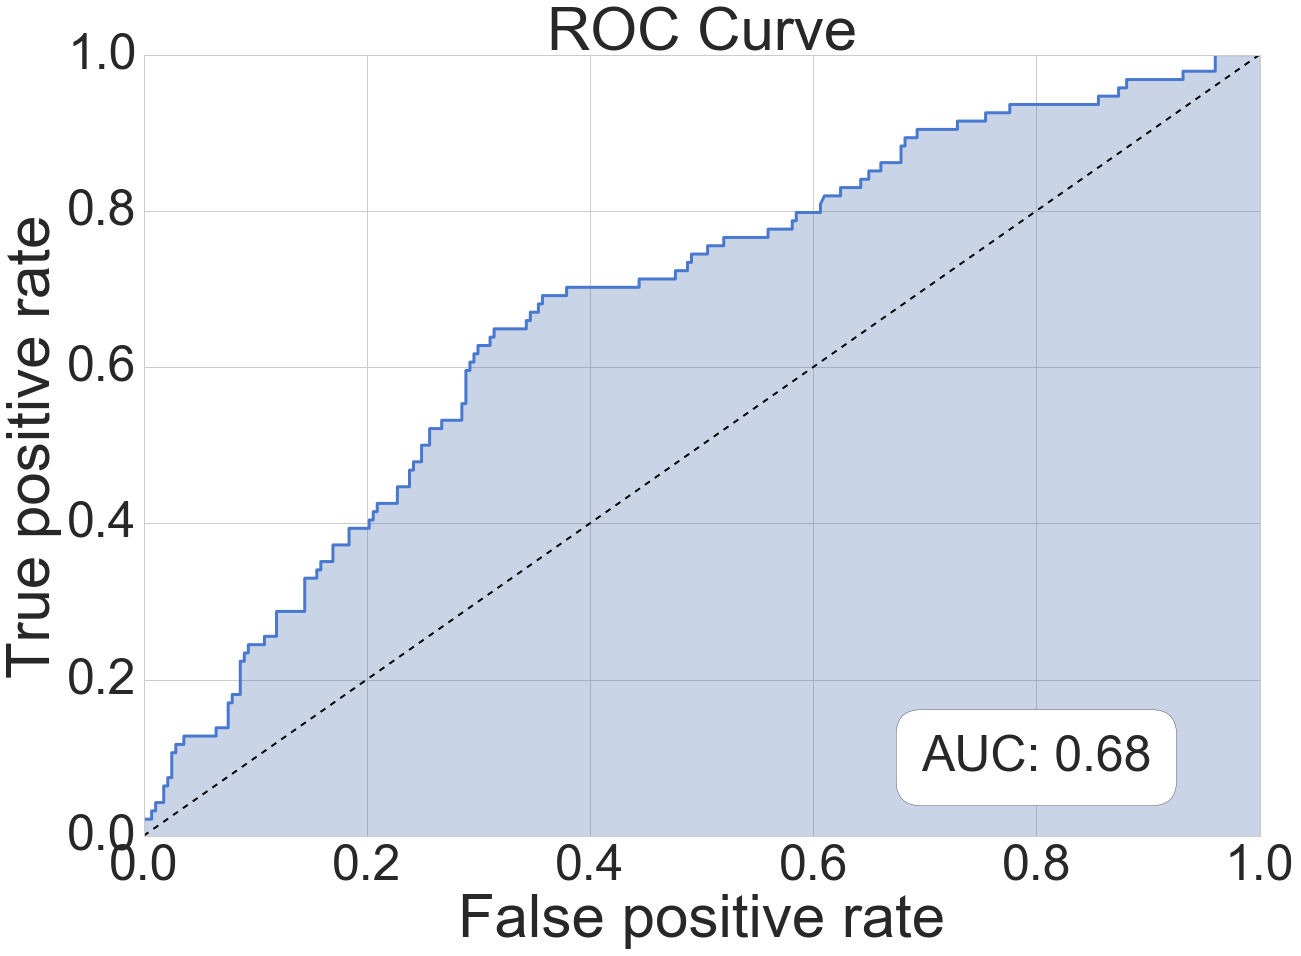

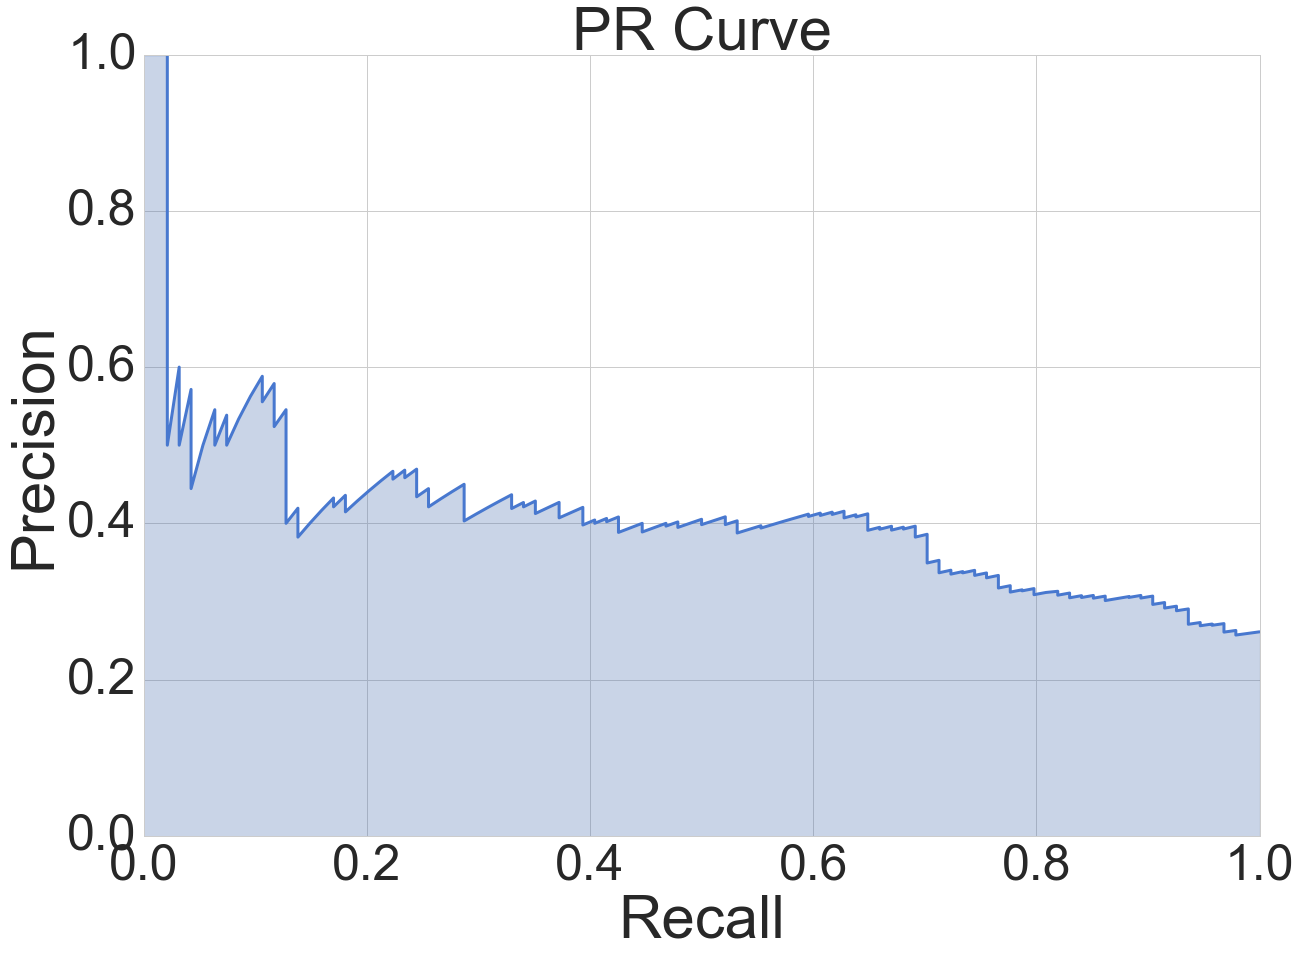

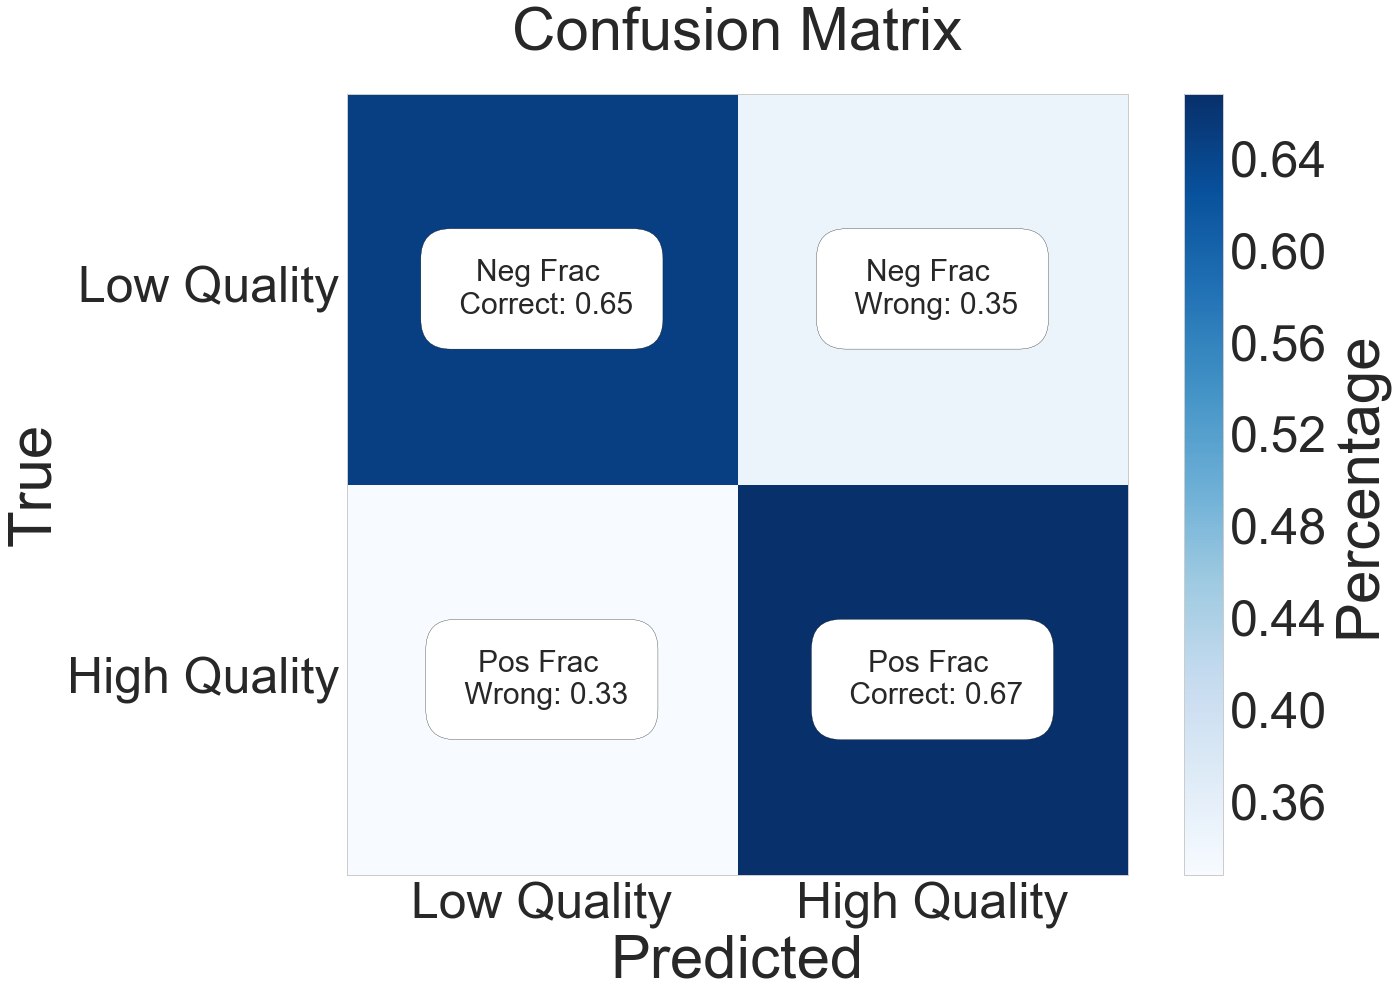

       F-Score  Precision    Recall  Support
Bad   0.737705   0.853081  0.649819      277
Good  0.496063   0.393750  0.670213       94


In [7]:
#Train Model
clf = ensemble.AdaBoostClassifier(
    ensemble.RandomForestClassifier(
        criterion = 'entropy',n_estimators=100,min_samples_leaf=3,max_features=None,random_state=102),random_state=102)

clf.fit(train_x,train_y)

#Evaluate on CV set while tuning
EvaluateModel(cv_x,cv_y)

# Saving Classifier

In [8]:
import pickle
save = False
if save == True:
    with open('image_classifier.pkl', 'wb') as f:
        pickle.dump(clf, f)

    with open('image_classifier_features.pkl', 'wb') as f:
        pickle.dump(features, f)

# Evaluating the Classifier

Accuracy:  0.690026954178
0.476818979671


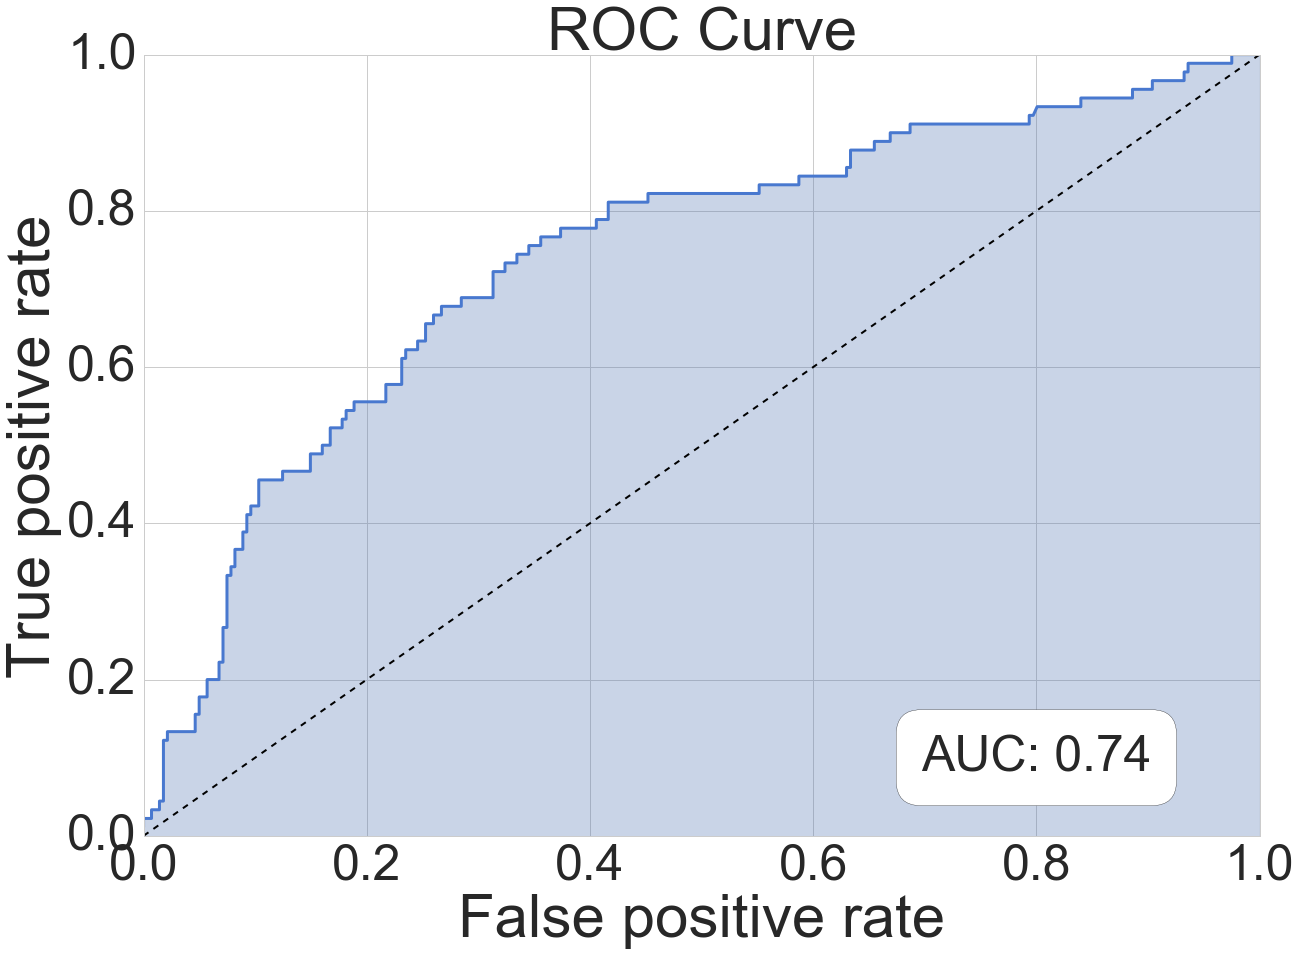

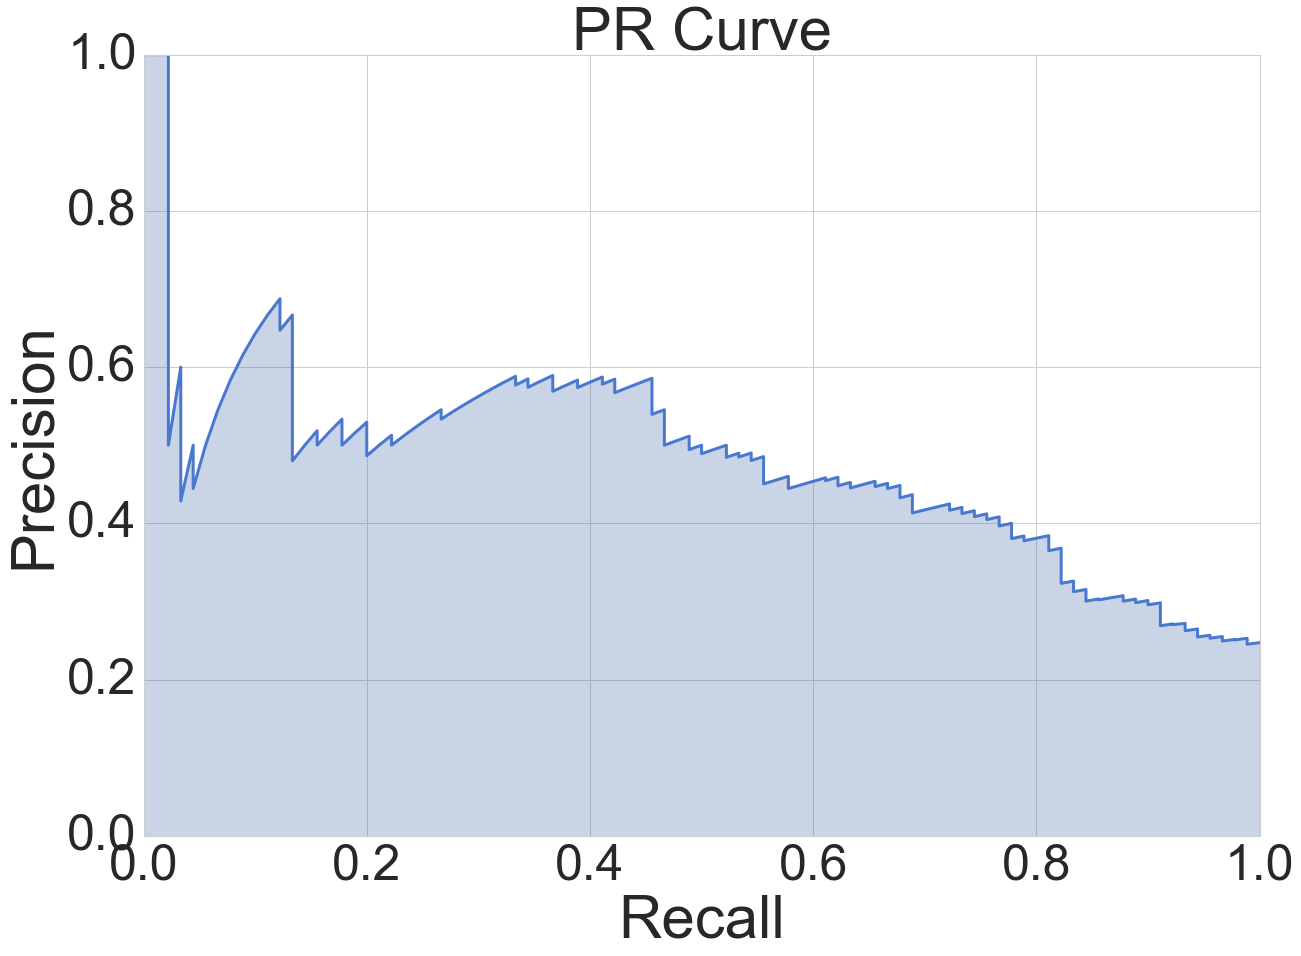

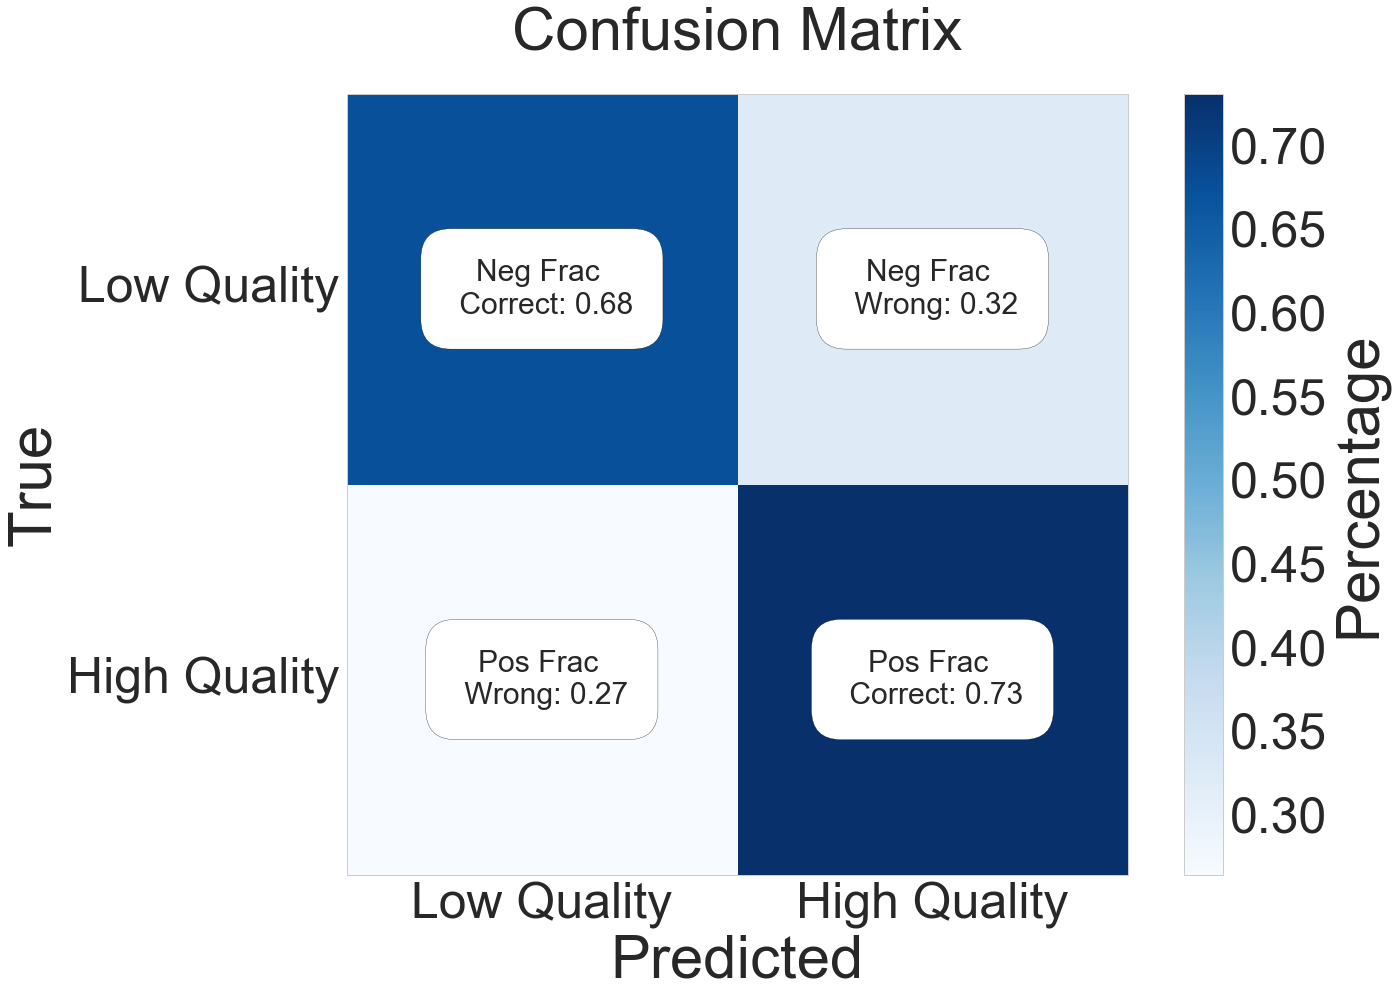

       F-Score  Precision    Recall  Support
Bad   0.767677   0.887850  0.676157      281
Good  0.534413   0.420382  0.733333       90


In [9]:
#Evaluate on CV set while tuning
EvaluateModel(test_x,test_y)

# Most important Features

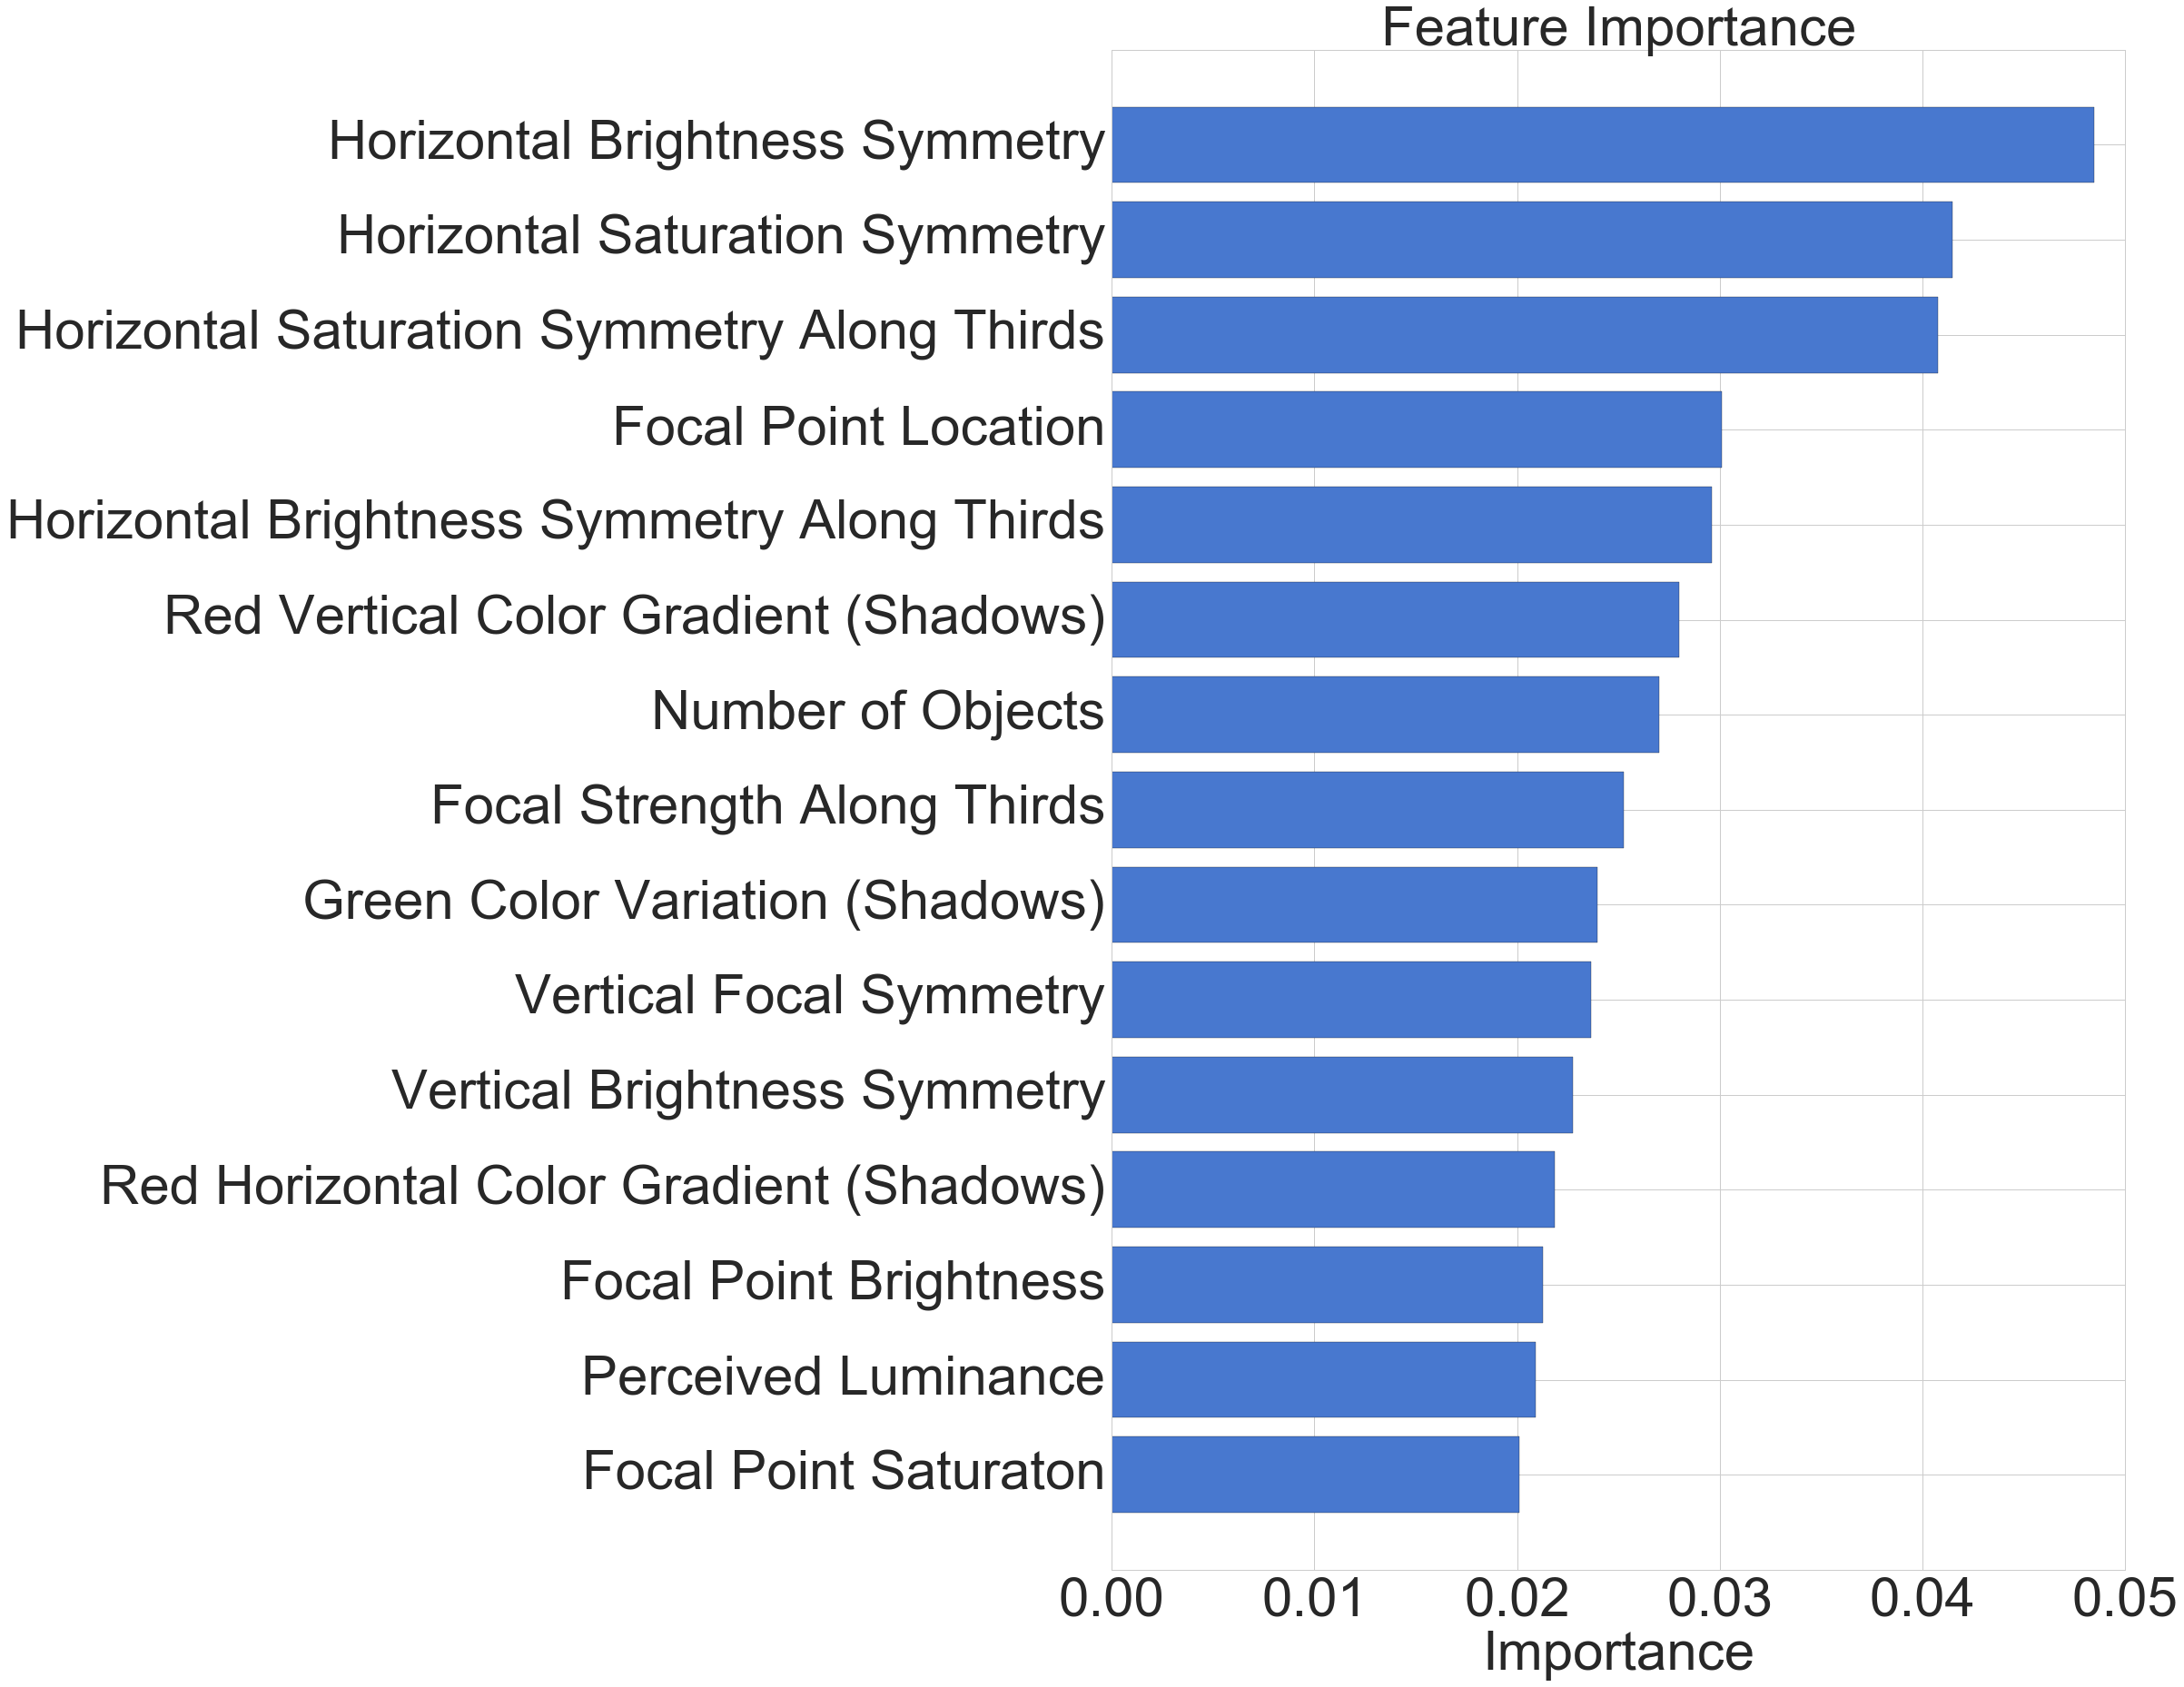

In [10]:
#Show top 15 features
sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sorted_importances = [importance for (importance,feature) in sorted(zip(importances,features),reverse=True)]
sorted_features = [feature for (importance,feature) in sorted(zip(importances,features),reverse=True)]   

name_dict = {
    "Horizontal_Value_Sym" : "Horizontal Brightness Symmetry",
    "Horizontal_Saturation_Sym" : "Horizontal Saturation Symmetry",
    "Thirds_Horizontal_Saliency_Sym" : "Horizontal Saturation Symmetry Along Thirds",
    "Thirds_To_Focal_Distance" : "Focal Point Location",
    "Thirds_Horizontal_Value_Sym" : "Horizontal Brightness Symmetry Along Thirds",
    "r_ygrad" : "Red Vertical Color Gradient (Shadows)",
    "Number_of_Contours" : "Number of Objects",
    "Thirds_Saliency" : "Focal Strength Along Thirds",
    "G_Width" : "Green Color Variation (Shadows)",
    "Thirds_Vertical_Saliency_Sym" : "Vertical Focal Symmetry",
    "Vertical_Value_Sym" : "Vertical Brightness Symmetry",
    "R_xgrad" : "Red Horizontal Color Gradient (Shadows)",
    "Salient_Value" : "Focal Point Brightness",
    "percieved_luminace" : "Perceived Luminance",
    "Salient_Saturation" : "Focal Point Saturaton",
    "Busyness" : "Busyness of Image"
}

sorted_importances = sorted_importances[:15]
sorted_features = sorted_features[:15]
plt.figure(figsize=(20,30))
plt.title("Feature Importance",size=60)
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color=blue, align="center")
plt.yticks(range(len(sorted_features),0,-1),size=20)
plt.xlabel('Importance',size=60)
ax=plt.gca()
ax.tick_params(labelsize=60) 
ax.set_yticklabels([name_dict[feat] for feat in sorted_features],fontsize=60)
plt.ylim([0, len(sorted_features)+1])
#plt.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/FeatureImporance.png',bbox_inches='tight')
plt.show()

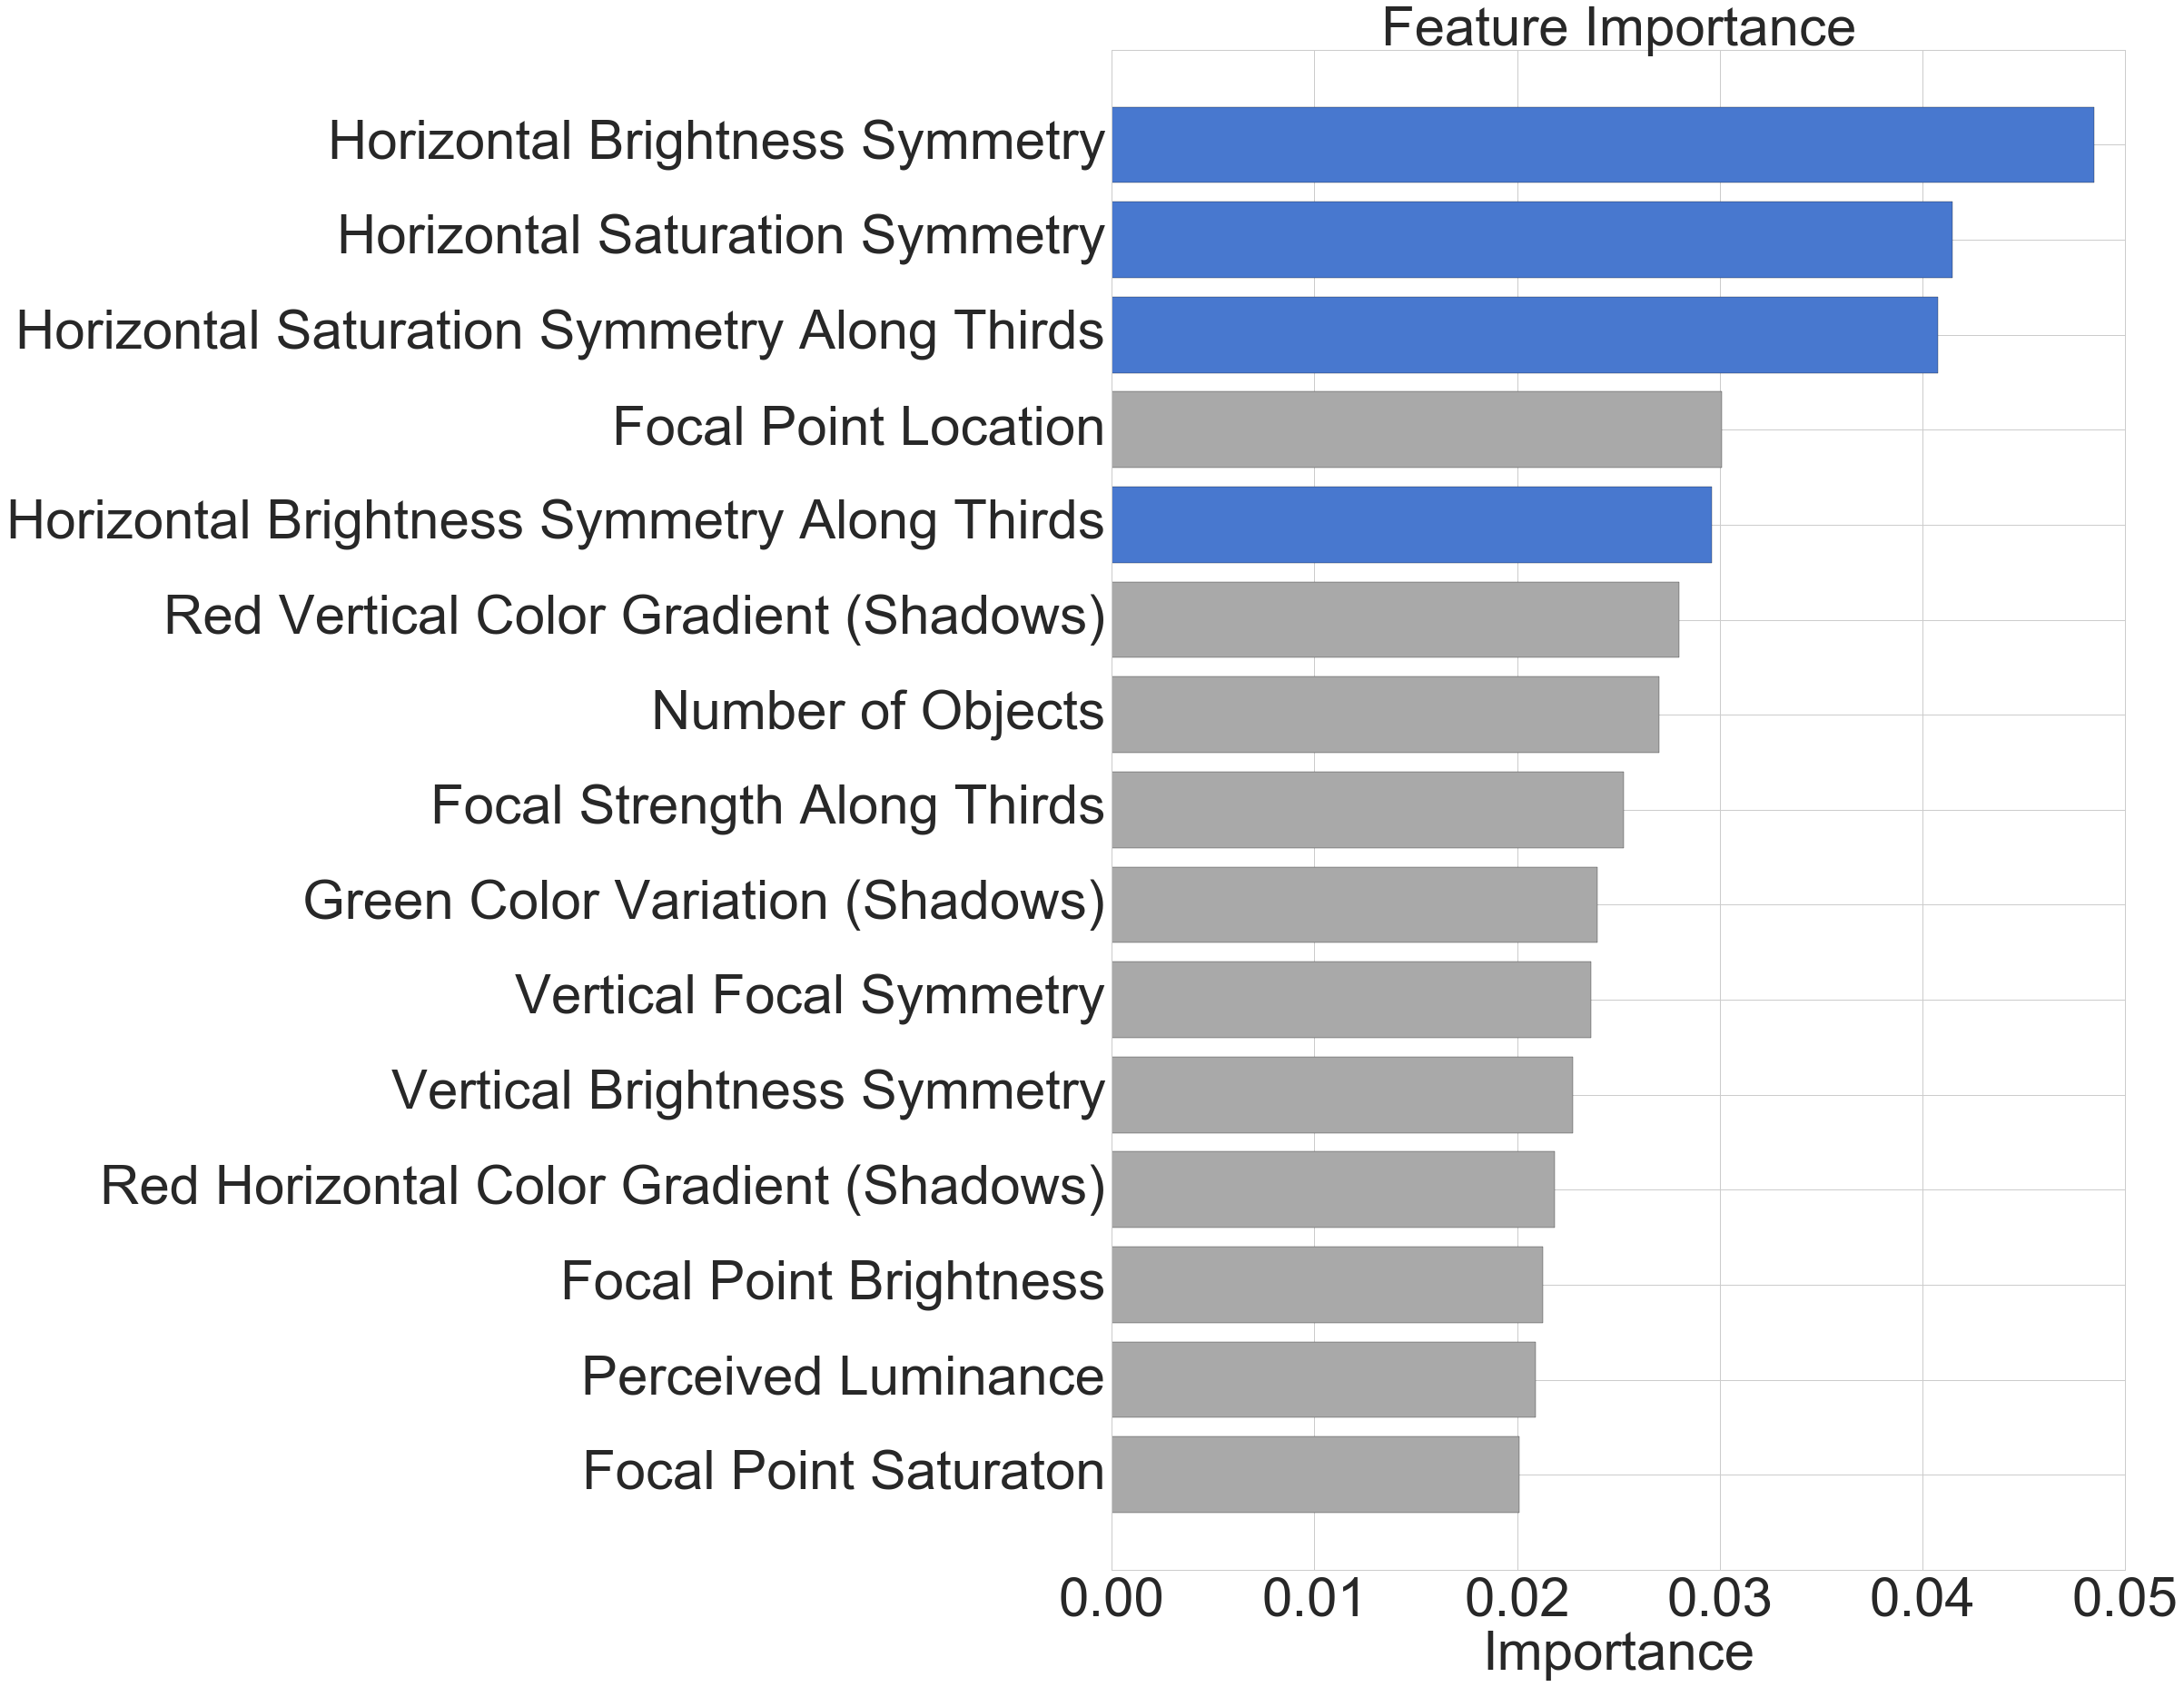

In [11]:
sorted_importances = sorted_importances[:15]
sorted_features = sorted_features[:15]
colors = [blue, blue, blue, 'darkgrey',blue,'darkgrey','darkgrey','darkgrey','darkgrey',\
          'darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','darkgrey']

plt.figure(figsize=(20,30))
plt.title("Feature Importance",size=60)
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color=colors, align="center")
plt.yticks(range(len(sorted_features),0,-1),size=20)
plt.xlabel('Importance',size=60)
ax=plt.gca()
ax.tick_params(labelsize=60) 
ax.set_yticklabels([name_dict[feat] for feat in sorted_features],fontsize=60)
plt.ylim([0, len(sorted_features)+1])
#plt.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/FeatureImporance_StepOne.png',bbox_inches='tight')
plt.show()

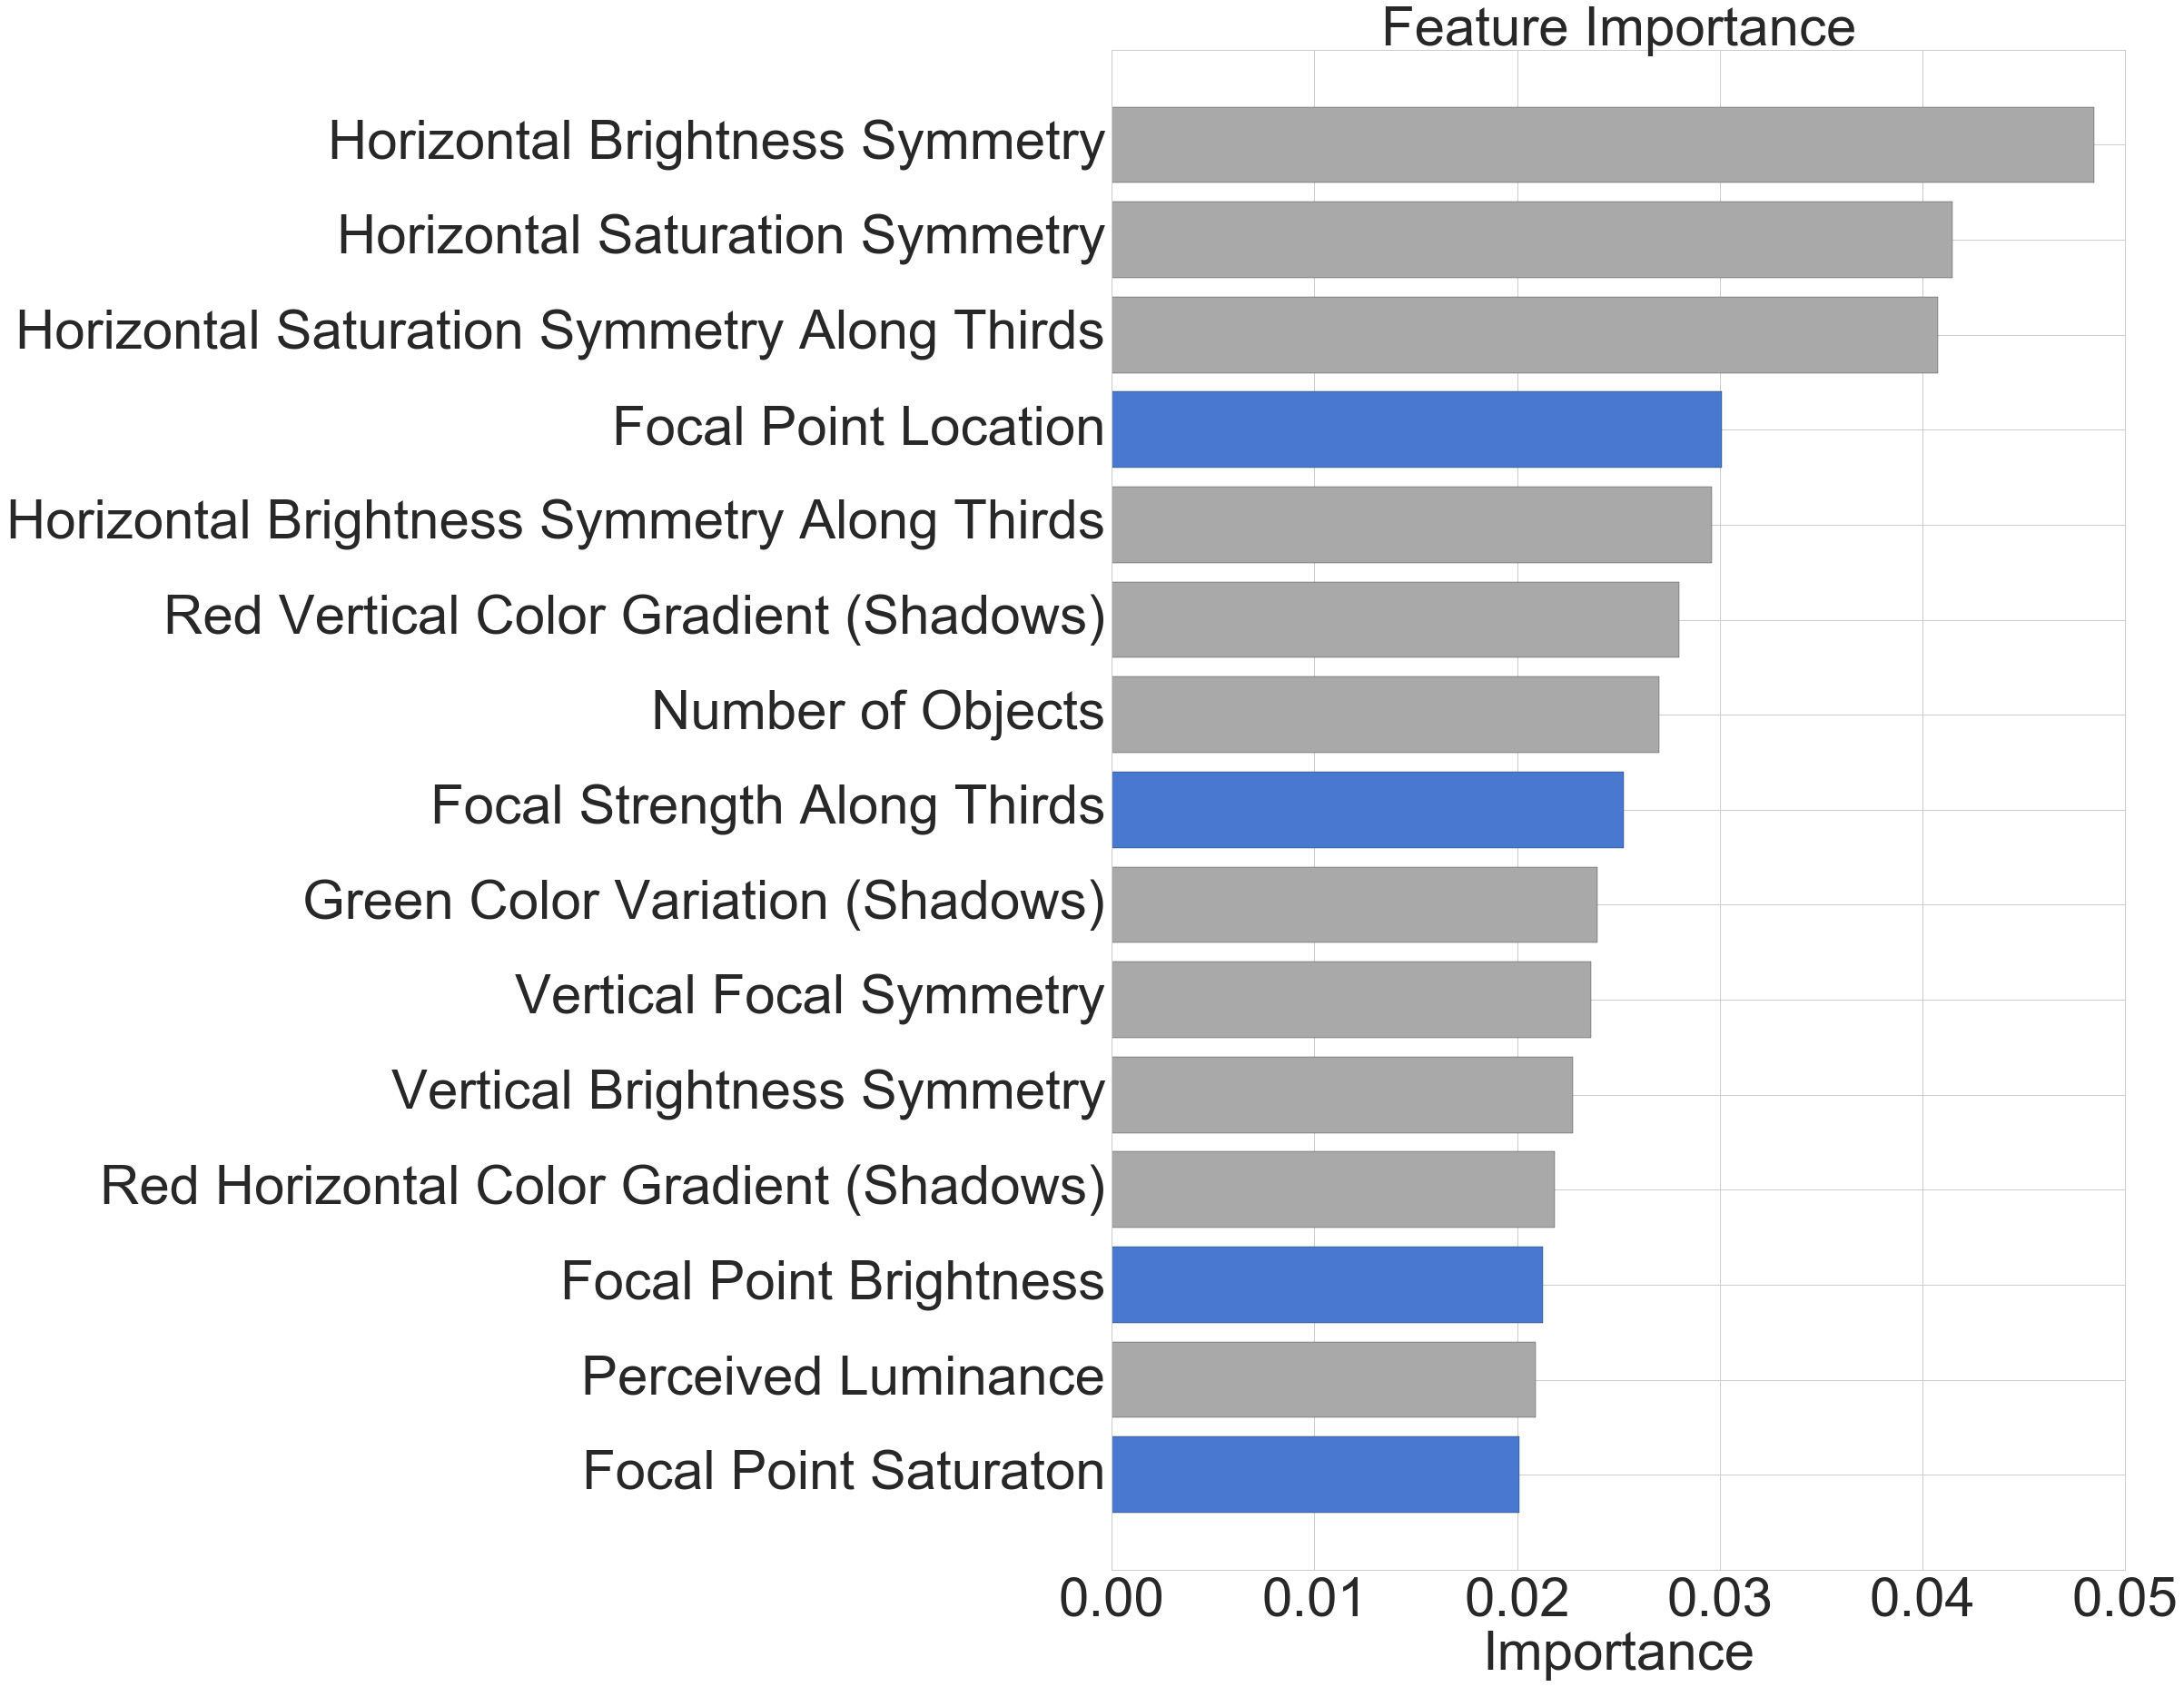

In [12]:
sorted_importances = sorted_importances[:15]
sorted_features = sorted_features[:15]
colors = ['darkgrey', 'darkgrey', 'darkgrey', blue,'darkgrey','darkgrey','darkgrey',blue,'darkgrey',\
          'darkgrey','darkgrey','darkgrey',blue,'darkgrey',blue]

plt.figure(figsize=(20,30))
plt.title("Feature Importance",size=60)
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color=colors, align="center")
plt.yticks(range(len(sorted_features),0,-1),size=20)
plt.xlabel('Importance',size=60)
ax=plt.gca()
ax.tick_params(labelsize=60) 
ax.set_yticklabels([name_dict[feat] for feat in sorted_features],fontsize=60)
plt.ylim([0, len(sorted_features)+1])
#plt.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/FeatureImporance_StepTwo.png',bbox_inches='tight')
plt.show()

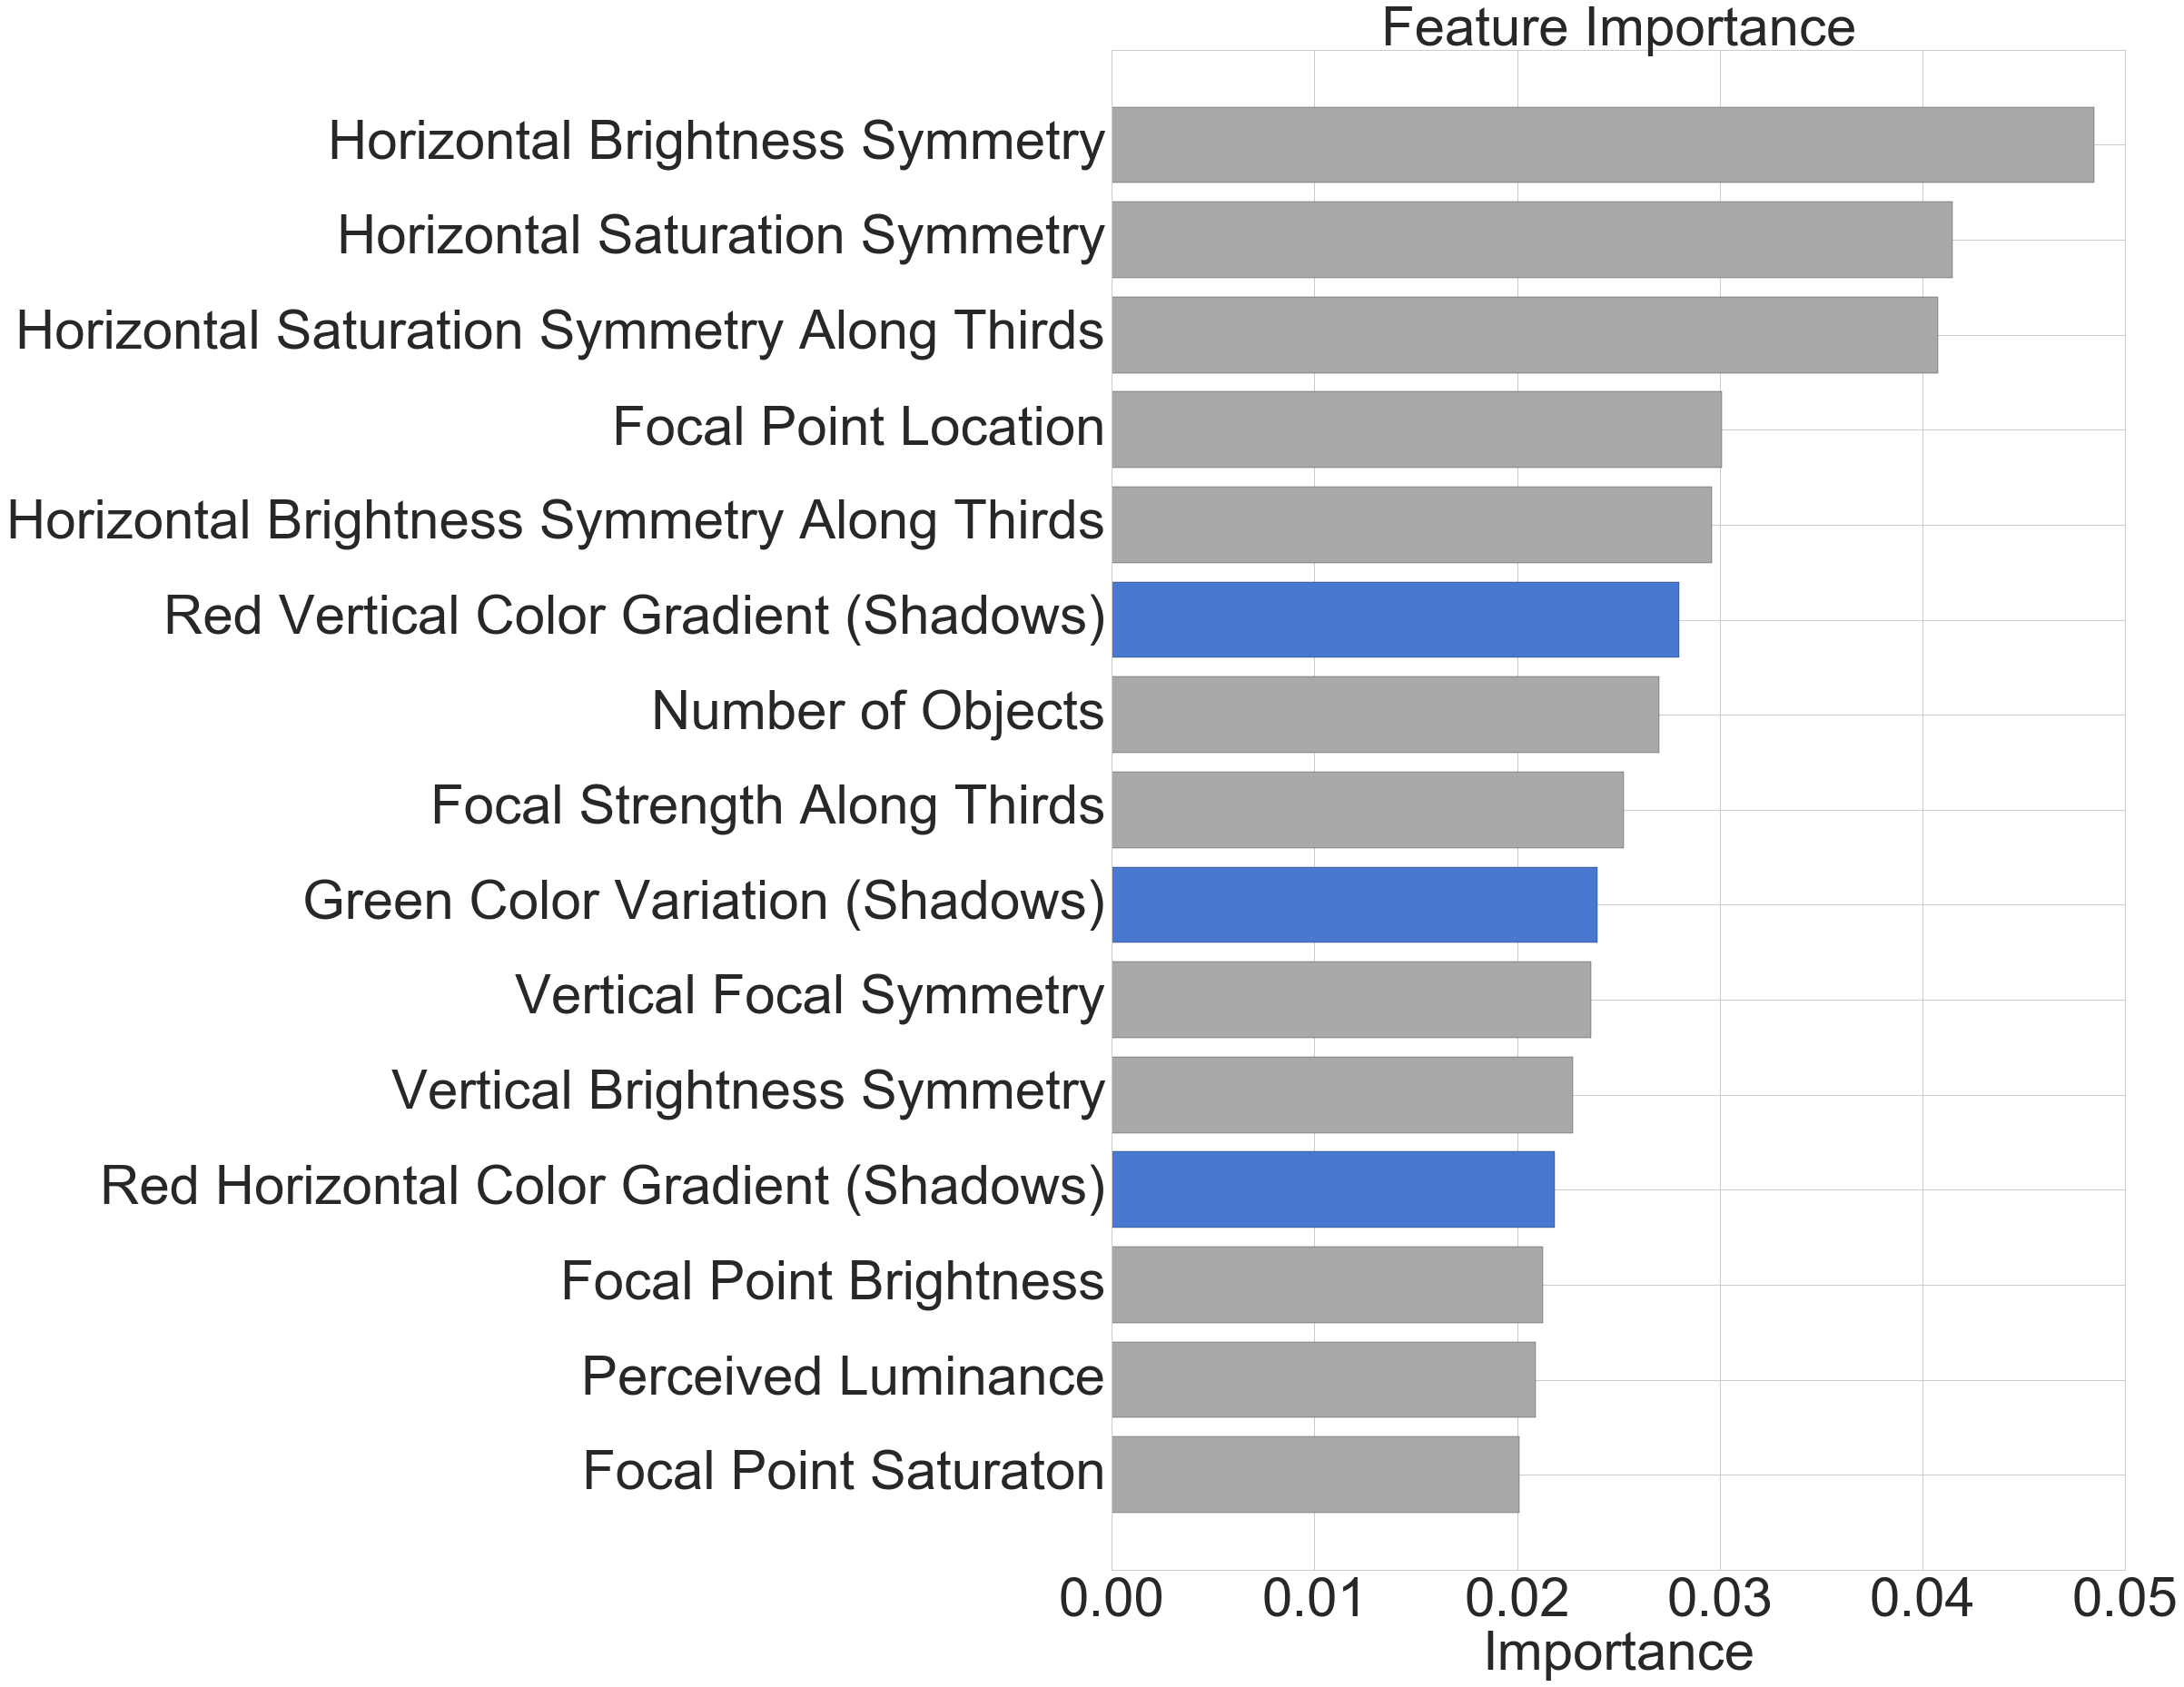

In [13]:
sorted_importances = sorted_importances[:15]
sorted_features = sorted_features[:15]
colors = ['darkgrey', 'darkgrey', 'darkgrey', 'darkgrey','darkgrey',blue,'darkgrey','darkgrey',blue,\
          'darkgrey','darkgrey',blue,'darkgrey','darkgrey','darkgrey']

plt.figure(figsize=(20,30))
plt.title("Feature Importance",size=60)
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color=colors, align="center")
plt.yticks(range(len(sorted_features),0,-1),size=20)
plt.xlabel('Importance',size=60)
ax=plt.gca()
ax.tick_params(labelsize=60) 
ax.set_yticklabels([name_dict[feat] for feat in sorted_features],fontsize=60)
plt.ylim([0, len(sorted_features)+1])
#plt.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/FeatureImporance_StepThree.png',bbox_inches='tight')
plt.show()

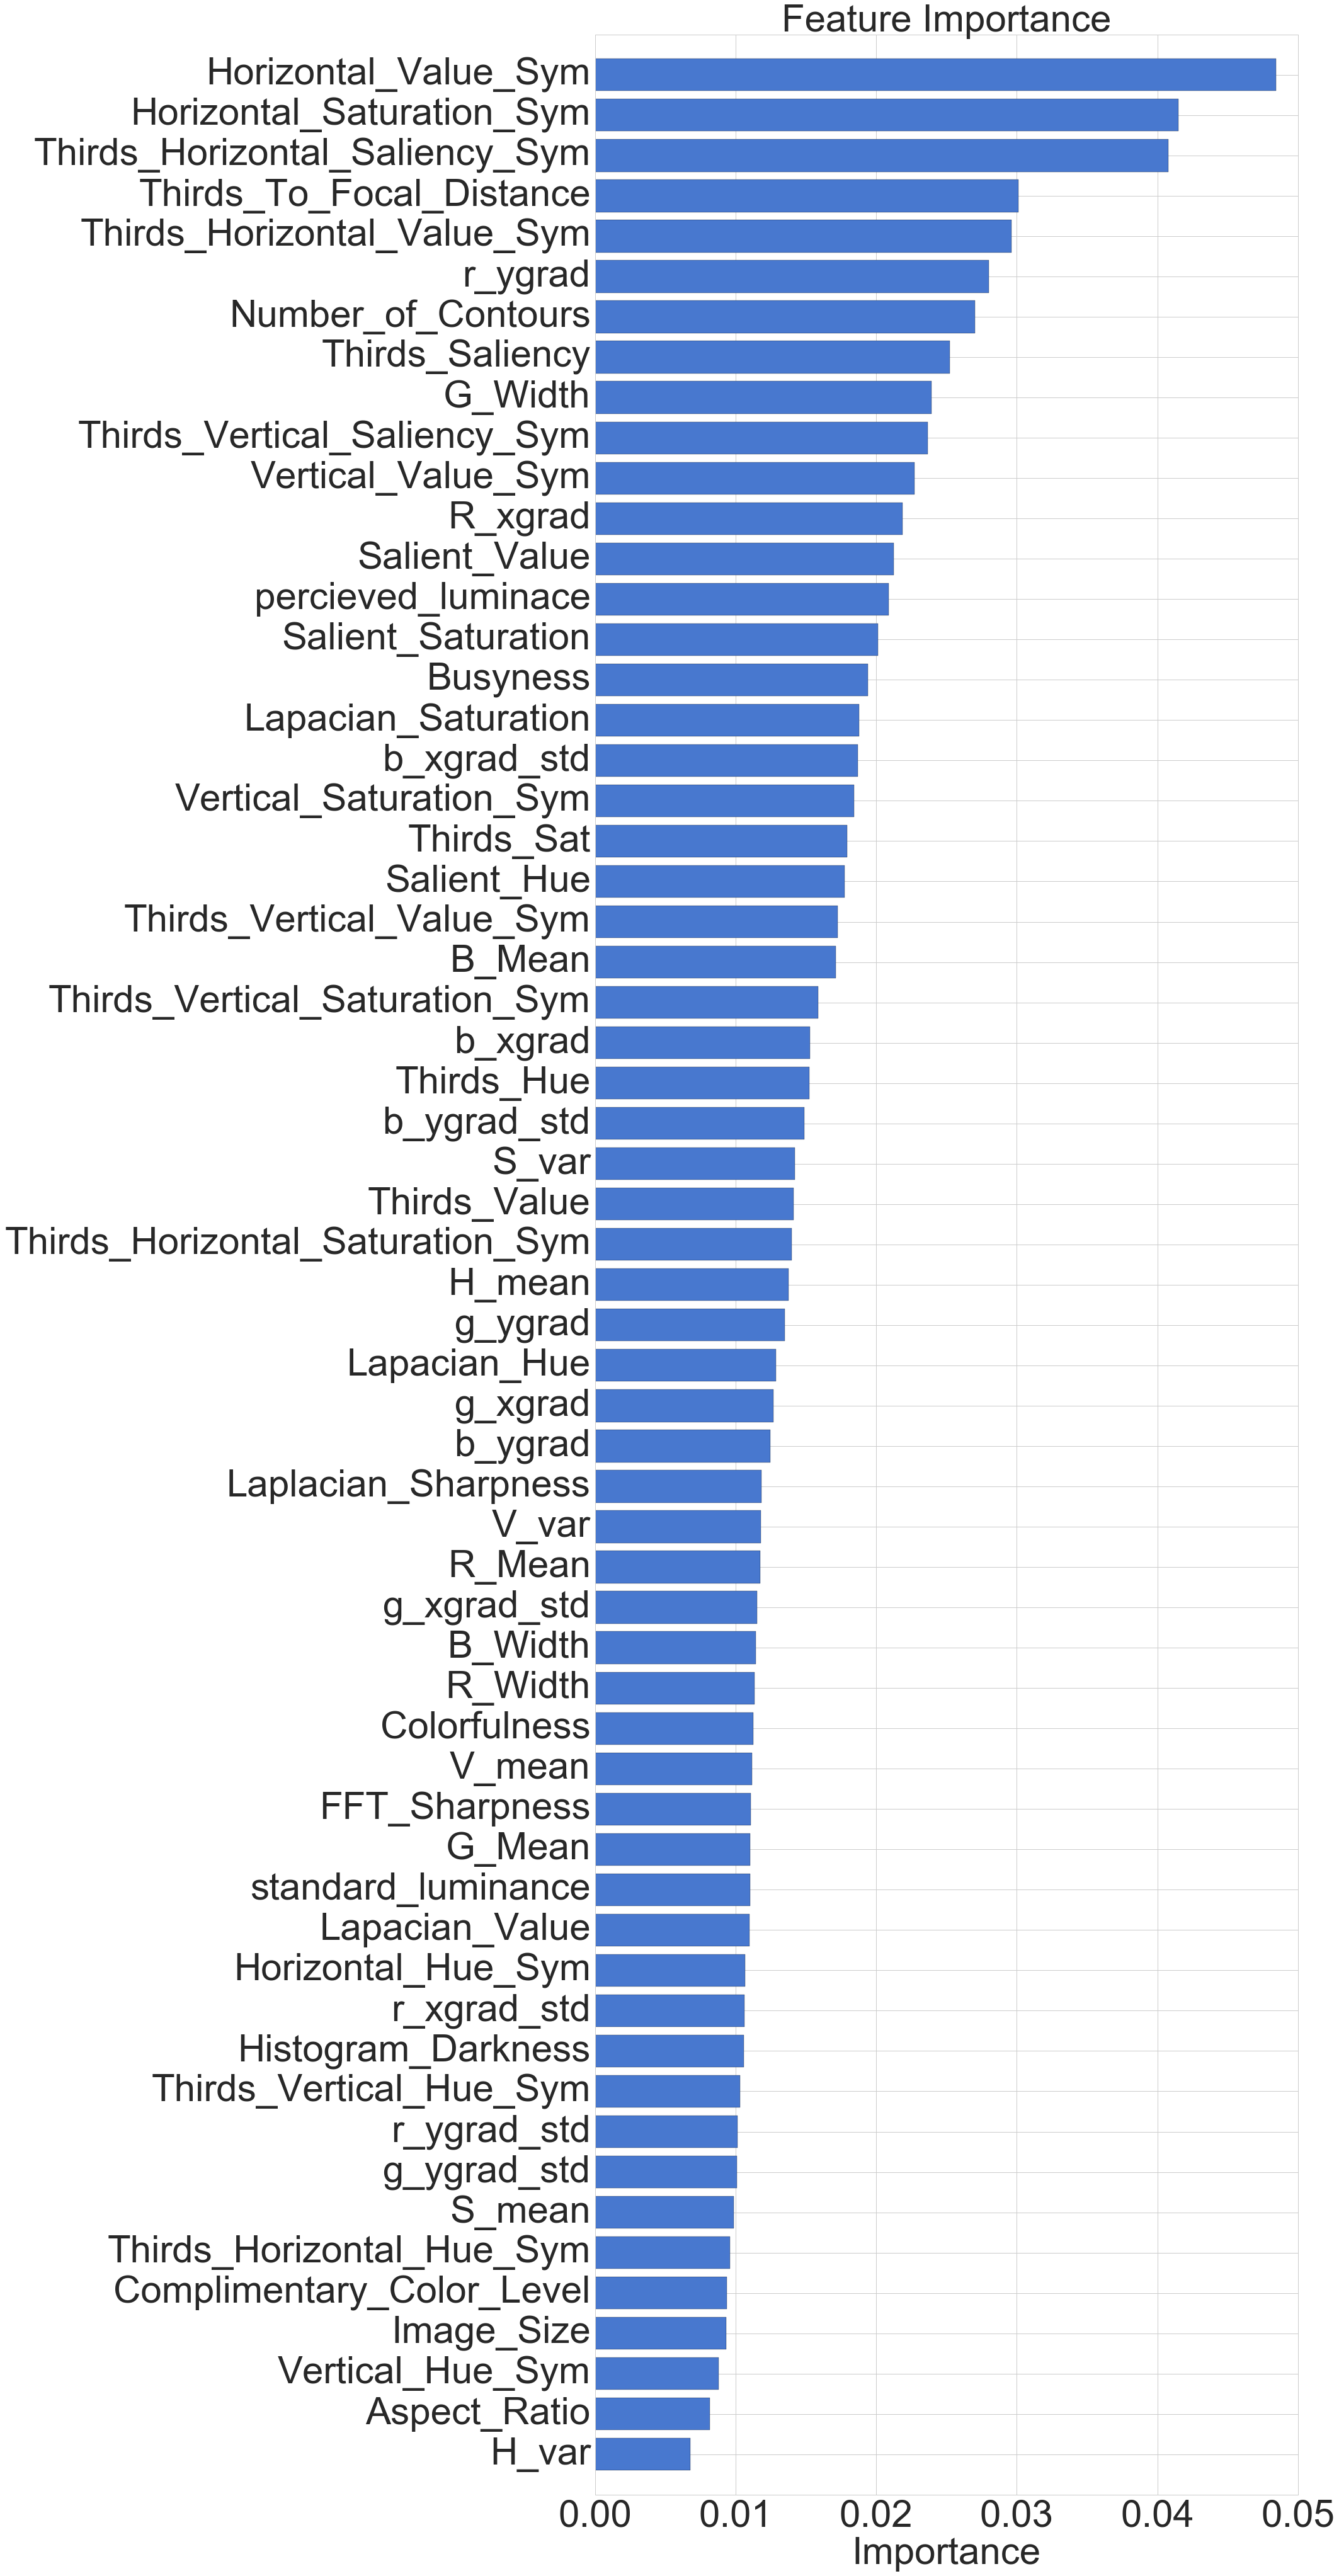

In [14]:
#Show all features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sorted_importances = [importance for (importance,feature) in sorted(zip(importances,features),reverse=True)]
sorted_features = [feature for (importance,feature) in sorted(zip(importances,features),reverse=True)]   


sorted_importances = sorted_importances[:]
sorted_features = sorted_features[:]
plt.figure(figsize=(20,70))
plt.title("Feature Importance",size=60)
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color=blue, align="center")
plt.yticks(range(len(sorted_features),0,-1),size=20)
plt.xlabel('Importance',size=60)
ax=plt.gca()
ax.tick_params(labelsize=60) 
ax.set_yticklabels([feat for feat in sorted_features],fontsize=60)
plt.ylim([0, len(sorted_features)+1])
#plt.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/AllFeatureImporance.png',bbox_inches='tight')
plt.show()

# Example of Decision Threshold

In [15]:
test['PredictedClass']=clf.predict(test[features])
test['IsEdit_Prob']=clf.predict_proba(test[features])[:,1]

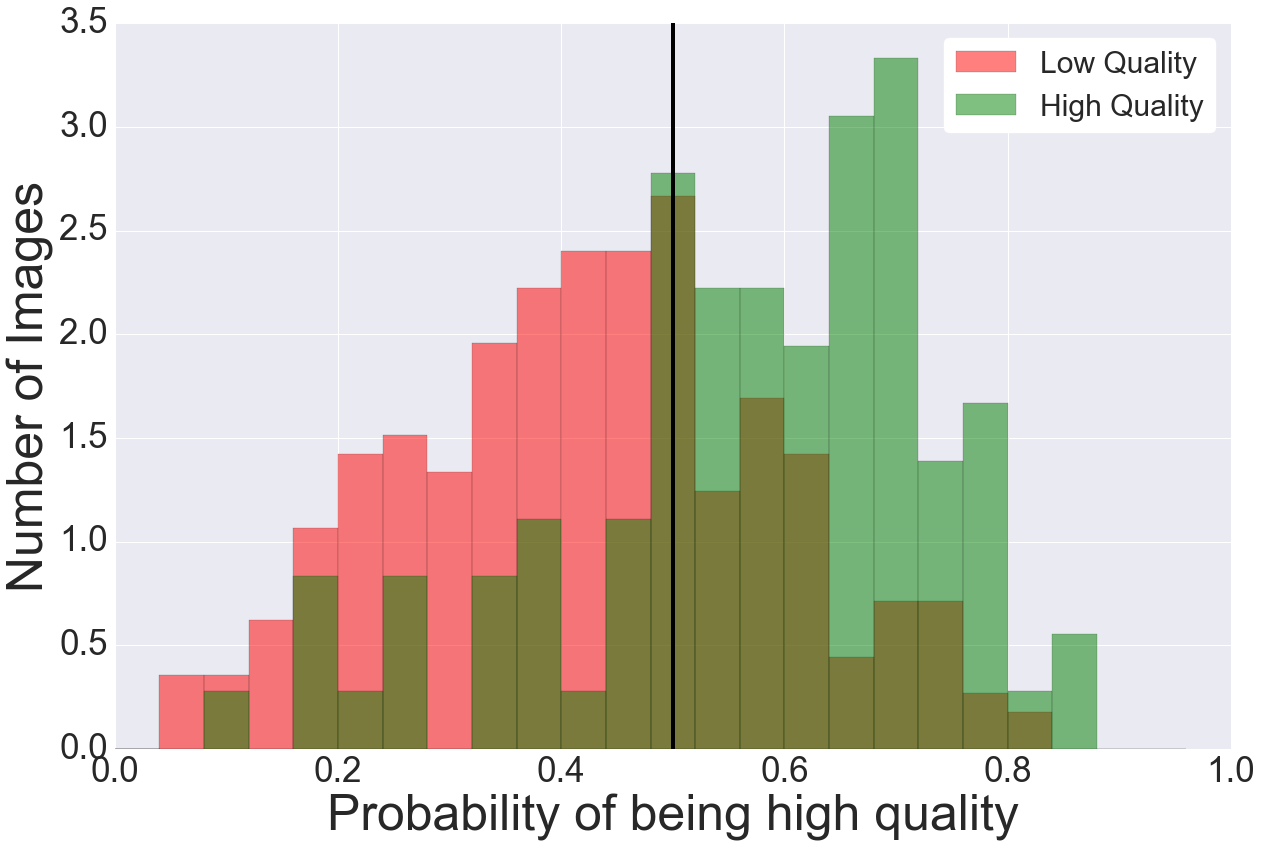

In [16]:
sns.set_style("darkgrid")

bins=np.arange(0,1,0.04)

fig = plt.figure(figsize=(20,13))
_,_,_ = plt.hist(test[test['Rating']==False]['IsEdit_Prob'],bins=bins,alpha=0.5,color='r',normed=True)
_,_,_ = plt.hist(test[test['Rating']==True]['IsEdit_Prob'],bins=bins,alpha=0.5,color='g',normed=True)
legend = plt.legend(['Low Quality','High Quality'],fontsize=30,frameon=True,fancybox=True)
frame = legend.get_frame()
frame.set_color('white')
plt.axvline(0.5,color='k',linewidth=4)
ax=plt.gca()
ax.tick_params(labelsize=35) 
plt.xlabel('Probability of being high quality',fontsize=50)
plt.ylabel('Number of Images',fontsize=50)
plt.show()
#fig.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/Threshold.png')


# Explaning results

True class: Good
Probability(Good) = 0.606904761905


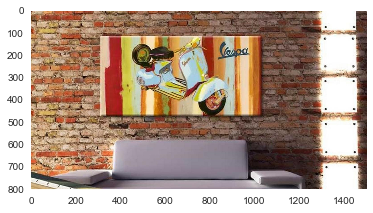

In [17]:

#From http://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html
from lime import lime_text,lime_tabular
from lime.lime_text import LimeTextExplainer
class_names=['Bad','Good']
explainer = lime_tabular.LimeTabularExplainer(np.array(train_x), feature_names=features, class_names=class_names, discretize_continuous=True)

idx = 50
df_idx = test.index[idx]
print('True class: %s' % class_names[test_y.loc[df_idx]])
print('Probability(Good) =', clf.predict_proba(test_x.loc[df_idx].values.reshape(1,-1))[0][1] )

exp = explainer.explain_instance(np.array(test_x.loc[df_idx]), clf.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True, show_all=False,)

#Get Image
image = UrlToImage(test.loc[df_idx]['path'])
image=CropImage(image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.grid(False)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


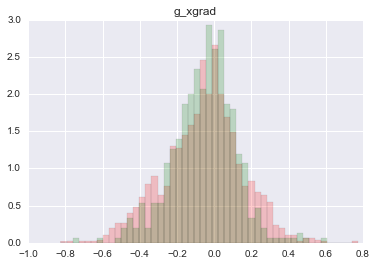

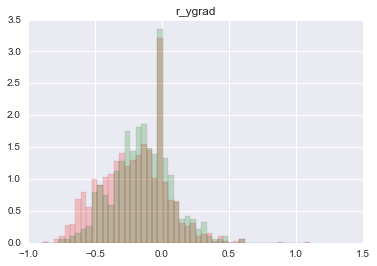

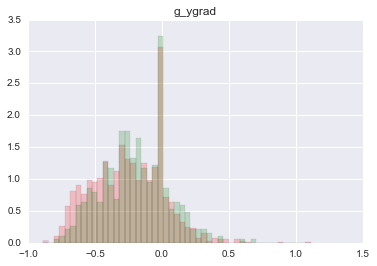

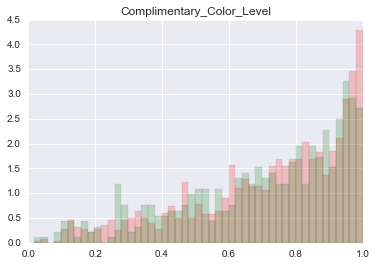

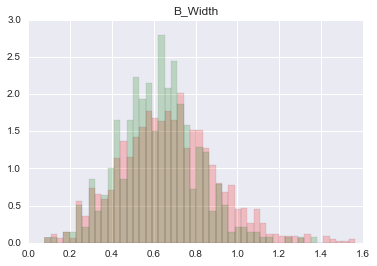

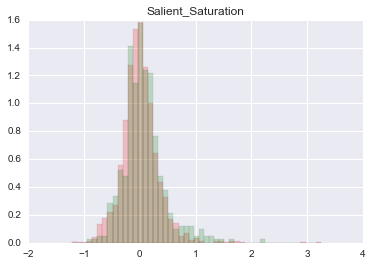

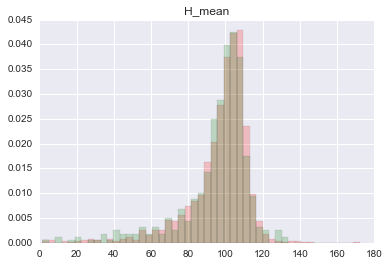

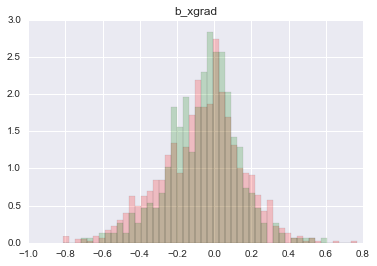

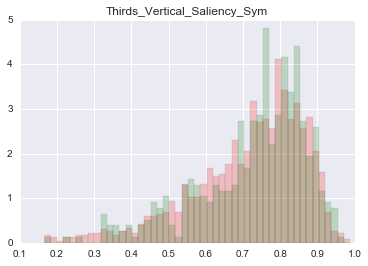

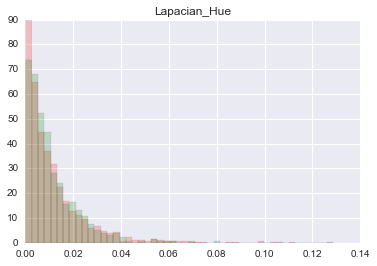

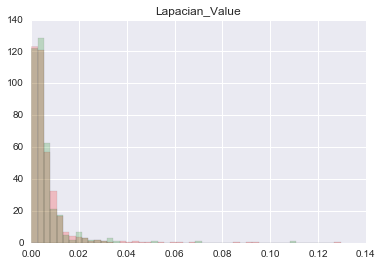

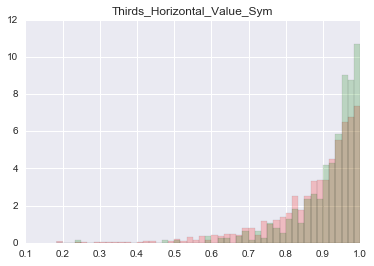

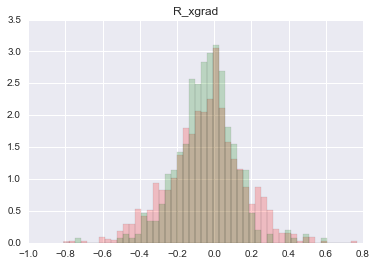

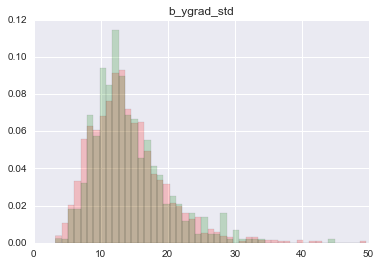

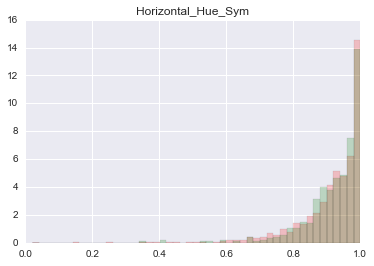

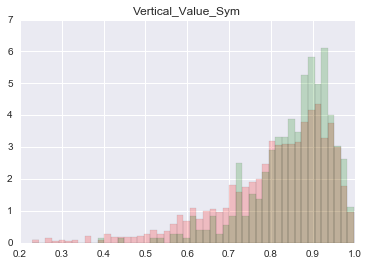

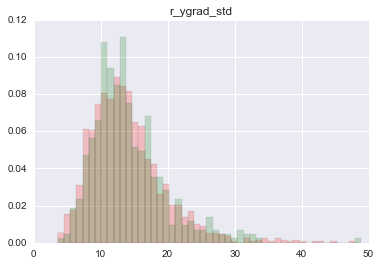

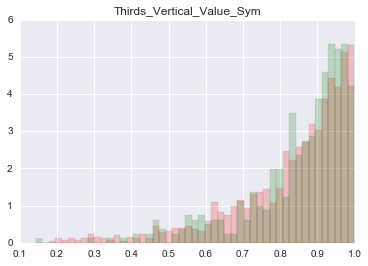

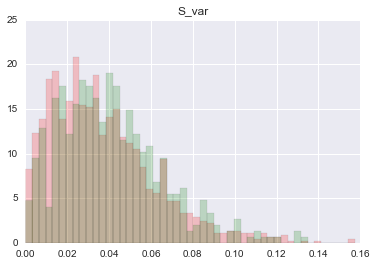

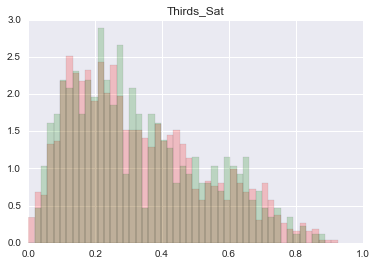

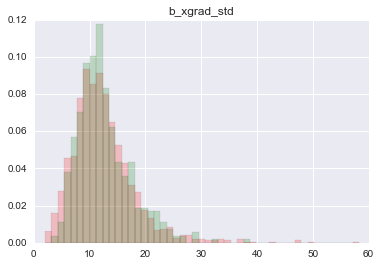

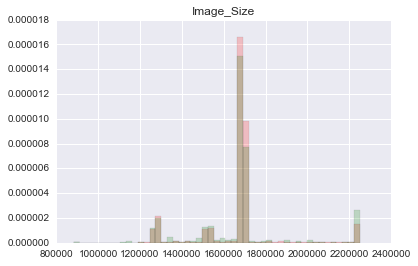

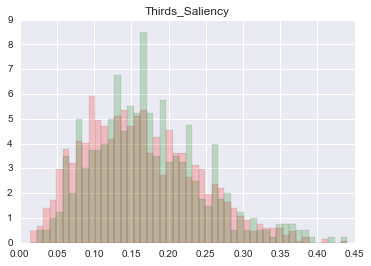

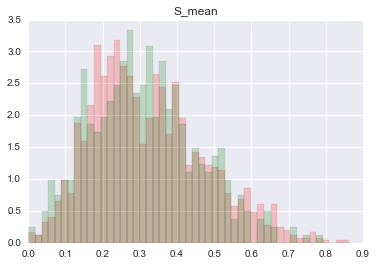

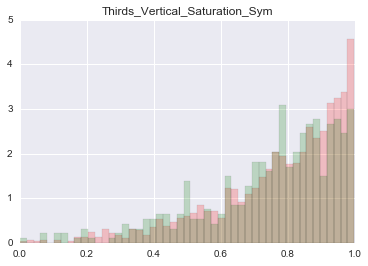

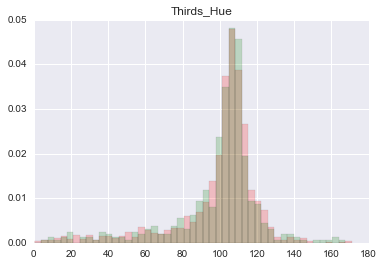

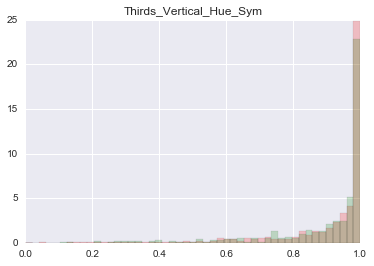

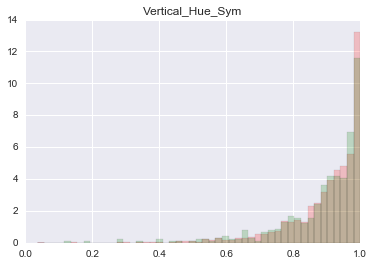

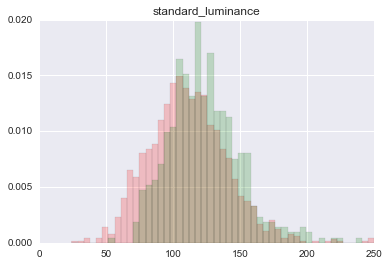

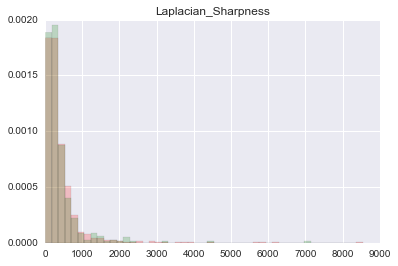

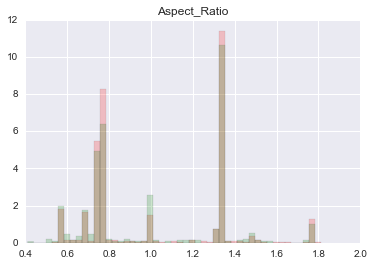

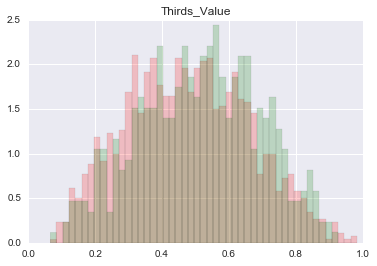

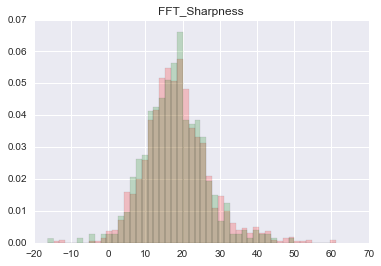

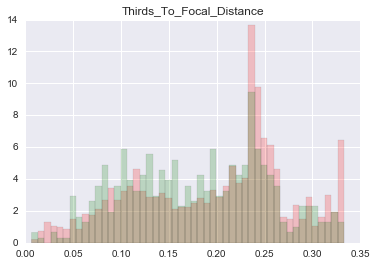

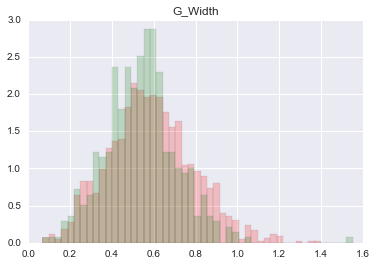

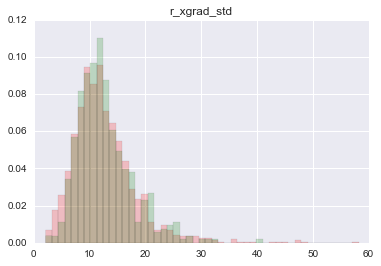

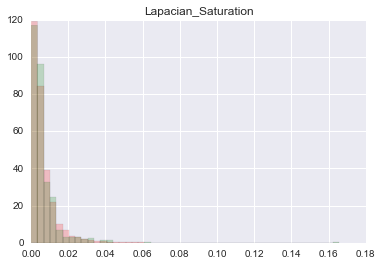

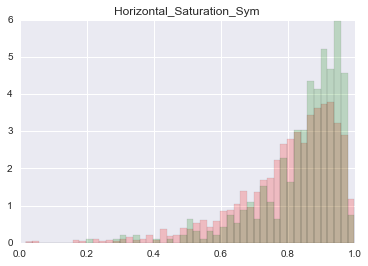

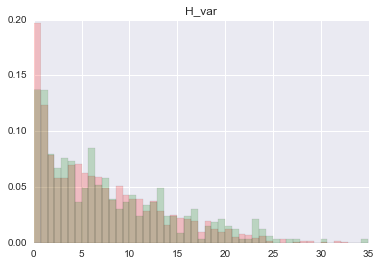

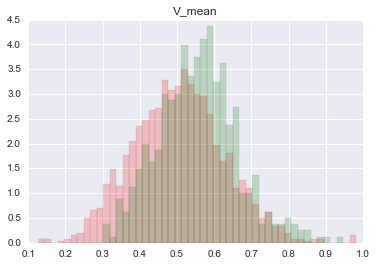

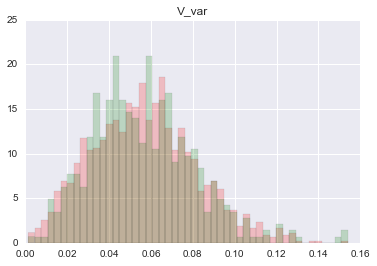

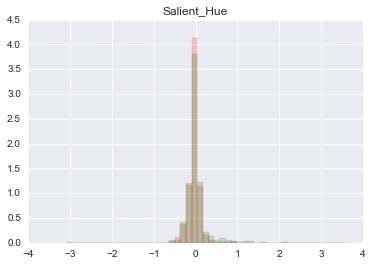

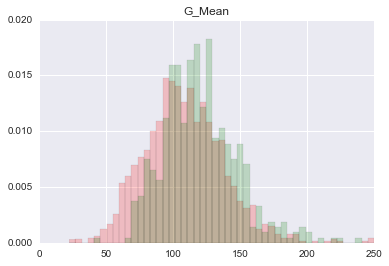

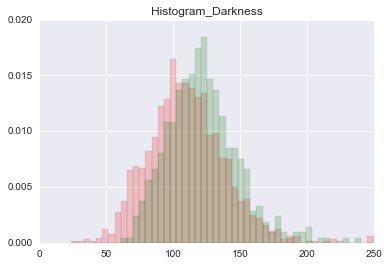

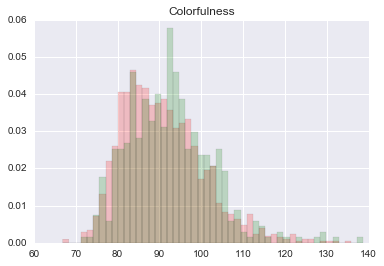

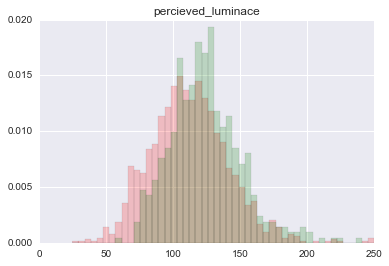

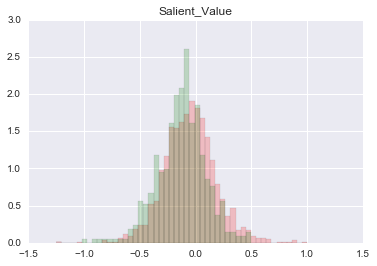

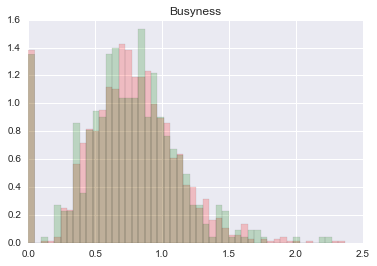

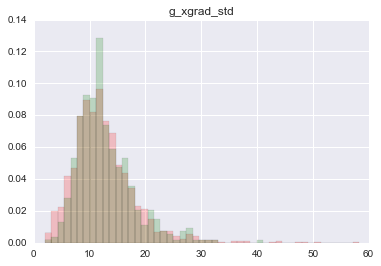

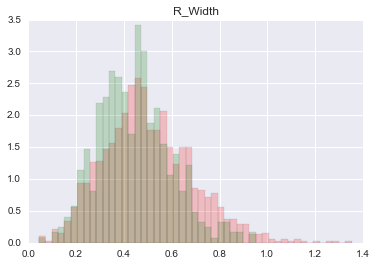

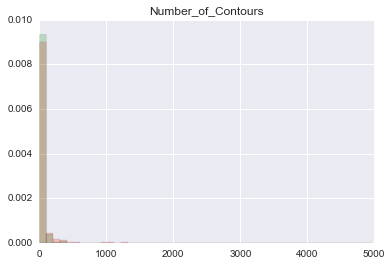

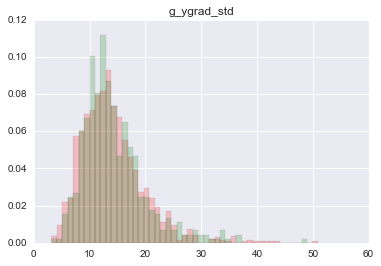

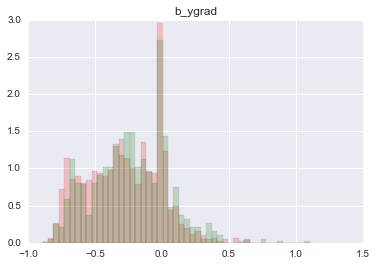

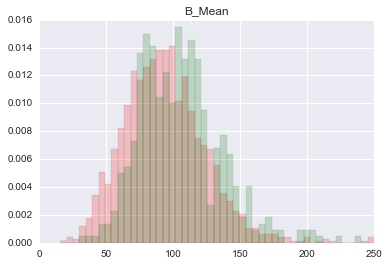

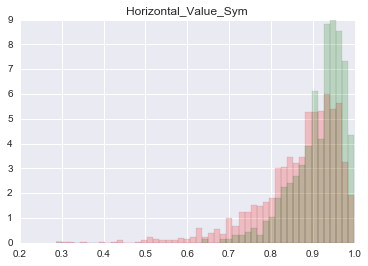

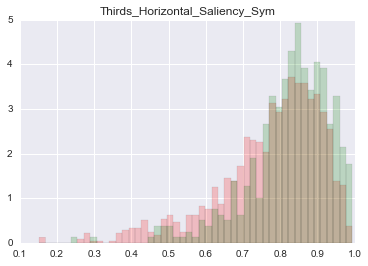

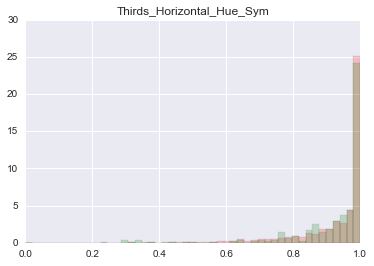

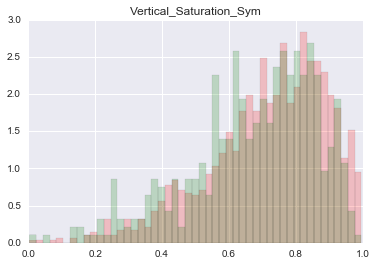

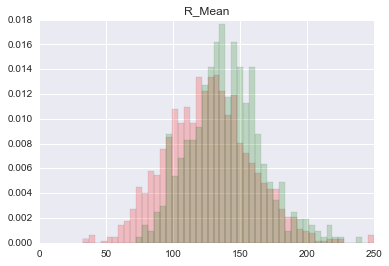

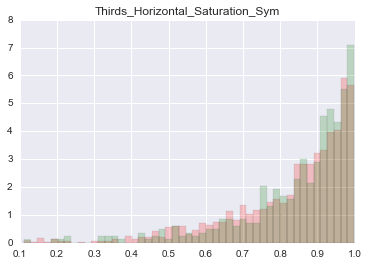

In [18]:
#histograms of each features
#Note: The majority of features look extemely similar, because if any one of the features is poor quality, the image it as well
#Hence, the nonlinearity of the problem and the poor performance of logistic reg.
for i in range(len(features)):
    feat = features[i]
    plt.figure()
    _,_,_ = plt.hist(df[df['Rating']==0][feat],bins=np.linspace(df[feat].min(),df[feat].max(),50),alpha=0.2,color='r',normed=True)
    _,_,_ = plt.hist(df[df['Rating']==1][feat],bins=np.linspace(df[feat].min(),df[feat].max(),50),alpha=0.2,color='g',normed=True)
    plt.title(feat)